In [640]:
import pandas as pd
import requests
import yfinance as yf

import warnings
# To ignore all warnings
warnings.filterwarnings("ignore")

In [641]:
factor_world1 = pd.read_csv('[developed]_[all_factors]_[monthly]_[vw_cap].csv')
factor_world2 = pd.read_csv('[developed]_[all_themes]_[monthly]_[vw_cap].csv')
factor_world5 = pd.concat([factor_world1, factor_world2], ignore_index=True)
factor_world3 = pd.read_csv('[developed]_[all_factors]_[daily]_[vw_cap].csv')
factor_world4 = pd.read_csv('[developed]_[all_themes]_[daily]_[vw_cap].csv')
factor_world6 = pd.concat([factor_world3, factor_world4], ignore_index=True)

In [642]:
# Disable SSL certificate verification
requests.packages.urllib3.disable_warnings()

# Fetch HTML content
response = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', verify=False)
html_content = response.content

# Read HTML content into pandas DataFrame
list_of_dfs = pd.read_html(html_content)
wikitable_sp_500 = list_of_dfs[0]
sp500_symbols = wikitable_sp_500['Symbol']
#Converting SP_500 tickers into list 
tickers = sp500_symbols.to_list()
#Remove some tickers as they create an error for the yfinance api
tickers[65] = 'BRK-B'
tickers[81] = 'BF-B'
tickers.remove('BF-B')
tickers.remove('BRK-B')
#Start Date for In Sample Historical Data
start = '1989-04-01'

#End Date for In Sample Historical Data
end   = '2023-12-31'
#Monthly Returns for Stocks in the List
monthly_data = yf.download(tickers,start=start,end=end,interval='1mo')
#Reformat Date Index 
monthly_data.index = pd.to_datetime(monthly_data.index)
monthly_data = monthly_data.tz_localize(None)
#Turn Adj Close prices into pct returns
monthly_data = monthly_data['Adj Close'].pct_change()
#Drop First row NaN values
monthly_data = monthly_data.drop(monthly_data.index[0])
#Drop if stock doesnt have data starting from the first index date
monthly_data = monthly_data.dropna(axis=1)
#Assign equal weight as base weights
base_w = {k: 1/len(monthly_data.columns) for k in monthly_data.columns}
base_w = pd.DataFrame.from_dict(base_w, orient='index', columns=['Weight'])
#Getting SP_500 data
spy = pd.DataFrame(yf.download('^GSPC',start=start,end=end,interval='1mo')['Adj Close'].pct_change())
#Dropping First Row(NaN) and formatting index to match monthly_data 
spy = spy.drop(spy.index[0]).tz_localize(None)
#Adding SP_500 data to monthly_data
monthly_data['SP_500'] = spy['Adj Close']

[*********************100%%**********************]  501 of 501 completed

4 Failed downloads:
['GEV', 'SOLV']: Exception("%ticker%: Data doesn't exist for startDate = 607410000, endDate = 1703998800")
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 1989-04-01 -> 2023-12-31)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed


In [643]:
factor_world=factor_world6


In [644]:
factor_world_1=factor_world.drop("location",axis=1)
factor_world_1.rename(columns={"name": "factors"}, inplace=True)

factor_world_1=factor_world_1.drop("n_countries",axis=1)
factor_world_1=factor_world_1.drop("freq",axis=1)
factor_world_1=factor_world_1.drop("direction",axis=1)
factor_world_weighting_monthly=factor_world_1.drop("weighting",axis=1)

# factor_world_weighting_monthly.drop_duplicates(subset=['factors', 'date'])

factor_world_weighting_monthly

,factors,date,ret
0,age,1986-01-06,0.019612
1,age,1986-01-09,-0.002344
2,age,1986-01-13,0.003336
3,age,1986-01-14,0.002809
4,age,1986-01-15,0.000409
...,...,...,...
1424499,value,2023-12-22,0.002617
1424500,value,2023-12-26,-0.000081
1424501,value,2023-12-27,-0.001039
1424502,value,2023-12-28,-0.002001


In [645]:
factor_world=factor_world6

In [646]:
unique_names = factor_world_weighting_monthly['factors'].unique()
unique_names
factor_world_weighting_monthly.dtypes

factor_world_weighting_monthly['date'] = pd.to_datetime(factor_world_weighting_monthly['date'])
z=factor_world_weighting_monthly.groupby(pd.Grouper(key='date', freq='M'))
result = factor_world_weighting_monthly.pivot(columns='factors', values='ret')
print(z)

In [647]:
pivot_df = factor_world_weighting_monthly.pivot(index='date', columns='factors')
# pivot_df.sort_index(inplace=True)
pivot_df.isna().sum()

pivot_df
factor_world_monthly=pivot_df[12:]
factor_world_monthly

common_index_dates = factor_world_monthly.index.intersection(monthly_data.index)
common_index_dates
factor_world7 = factor_world_monthly.loc[common_index_dates]
factor_world7

factor_world_monthly=factor_world7


In [648]:
factor_world_monthly

ret                                                    \
factors     accruals       age   aliq_at  aliq_mat  ami_126d     at_be   
1989-05-01       NaN  0.022890       NaN       NaN       NaN       NaN   
1989-06-01 -0.000040  0.018662 -0.000945       NaN       NaN  0.007282   
1989-08-01  0.000589 -0.002459  0.001585  0.001601       NaN  0.000031   
1989-09-01  0.000729  0.011167  0.003246 -0.000909       NaN -0.001310   
1989-11-01  0.001055  0.002134  0.001323  0.004515       NaN -0.002088   
...              ...       ...       ...       ...       ...       ...   
2023-06-01 -0.001359 -0.002322 -0.001073 -0.001700 -0.003813 -0.000896   
2023-08-01  0.000593  0.000537 -0.000184 -0.001832  0.000999  0.000546   
2023-09-01 -0.001180 -0.001573  0.000881 -0.002450 -0.000604 -0.000092   
2023-11-01 -0.000870 -0.003933  0.002266  0.001692 -0.004570  0.000298   
2023-12-01 -0.001113 -0.006484  0.000625 -0.004963 -0.001339 -0.001414   

                                                      ...               \
factors       at_gr1     at_me at_turnover   be_gr1a  ... taccruals_ni   
1989-05-01       NaN       NaN         NaN       NaN  ...          NaN   
1989-06-01 -0.001301  0.001645    0.004073 -0.005497  ...     0.000947   
1989-08-01 -0.000492  0.000229    0.001247  0.001944  ...     0.000934   
1989-09-01  0.000051  0.000451    0.002651  0.003872  ...     0.000761   
1989-11-01  0.002537 -0.001411    0.001795  0.003840  ...    -0.000399   
...              ...       ...         ...       ...  ...          ...   
2023-06-01  0.001053 -0.000107    0.001435 -0.001443  ...    -0.000893   
2023-08-01 -0.001638 -0.001783    0.003988 -0.000381  ...     0.001077   
2023-09-01  0.000189  0.002162    0.001174 -0.002068  ...    -0.001775   
2023-11-01 -0.001364  0.000487   -0.002202  0.000905  ...    -0.002363   
2023-12-01  0.001313  0.003473   -0.000848  0.000522  ...    -0.003071   

                                                                            \
factors    tangibility  tax_gr1a turnover_126d turnover_var_126d     value   
1989-05-01         NaN       NaN           NaN               NaN  0.001237   
1989-06-01   -0.005963  0.007280           NaN               NaN  0.001407   
1989-08-01   -0.002071  0.000231           NaN               NaN -0.000560   
1989-09-01   -0.003429 -0.002143           NaN               NaN -0.000047   
1989-11-01    0.001783 -0.002464           NaN               NaN -0.001119   
...                ...       ...           ...               ...       ...   
2023-06-01   -0.001386  0.002141     -0.003507          0.000222 -0.000507   
2023-08-01    0.001167  0.002442      0.000420         -0.002209  0.000304   
2023-09-01    0.001688  0.002010     -0.000598          0.000219  0.002893   
2023-11-01   -0.002690  0.001368     -0.000498          0.004919  0.000318   
2023-12-01    0.000813 -0.002367     -0.000914          0.000948  0.002732   

                                                                        
factors      z_score zero_trades_126d zero_trades_21d zero_trades_252d  
1989-05-01       NaN              NaN             NaN              NaN  
1989-06-01  0.007697              NaN             NaN              NaN  
1989-08-01  0.001946              NaN             NaN              NaN  
1989-09-01 -0.000243              NaN             NaN              NaN  
1989-11-01 -0.001704              NaN             NaN              NaN  
...              ...              ...             ...              ...  
2023-06-01 -0.000712        -0.003429       -0.002232        -0.004056  
2023-08-01  0.000206         0.000192        0.000140         0.000120  
2023-09-01 -0.000193        -0.000664        0.000163        -0.000201  
2023-11-01  0.001248        -0.000480       -0.000518        -0.000504  
2023-12-01 -0.004516        -0.000962        0.000017        -0.001169  

[273 rows x 166 columns]

In [649]:
factor_world_monthly.isna().sum()

     factors         
ret  accruals             2
     age                  2
     aliq_at              2
     aliq_mat             3
     ami_126d            28
                         ..
     value                0
     z_score              1
     zero_trades_126d    28
     zero_trades_21d     29
     zero_trades_252d    30
Length: 166, dtype: int64

In [650]:
df_dropped = factor_world_monthly.dropna(thresh=len(factor_world_monthly) - 30, axis=1)

# Identify features with missing values between 5 and 30
missing_count = factor_world_monthly.isnull().sum()
interpolate_features = missing_count[(missing_count >= 5) & (missing_count <= 30)].index

# Interpolate missing values for features with 5 to 30 missing values
df_interpolated = df_dropped.copy()
df_interpolated[interpolate_features] = df_interpolated[interpolate_features].interpolate(method='linear', axis=0)

# Identify features with 5 or fewer missing values
fill_median_features = missing_count[missing_count <= 5].index

# Fill missing values with median for features with 5 or fewer missing values
df_filled = df_interpolated.copy()
for feature in fill_median_features:
    median_value = df_filled[feature].median()
    df_filled[feature].fillna(median_value, inplace=True)

# Now df_filled contains the DataFrame with dropped, interpolated, and median-filled missing values


In [651]:
import pandas as pd

# Assuming you have a DataFrame named 'df'

# Identify features with missing values between 5 and 30
missing_count = df_filled.isna().sum()
interpolate_features = missing_count[(missing_count >= 5) & (missing_count <= 30)].index

# Interpolate missing values for features with 5 to 30 missing values
df_interpolated = df_filled.copy()
df_interpolated[interpolate_features] = df_interpolated[interpolate_features].interpolate(method='linear', axis=0)

# Identify features with 5 or fewer missing values
fill_median_features = missing_count[missing_count <= 5].index

# Fill missing values with median for features with 5 or fewer missing values
for feature in fill_median_features:
    median_value = df_interpolated[feature].median()
    df_interpolated[feature].fillna(median_value, inplace=True)

# Now df_interpolated contains the DataFrame with interpolated and median-filled missing values


In [652]:
df_interpolated

ret                                                    \
factors     accruals       age   aliq_at  aliq_mat  ami_126d     at_be   
1989-05-01 -0.000007  0.022890 -0.000223 -0.000155       NaN  0.000209   
1989-06-01 -0.000040  0.018662 -0.000945 -0.000155       NaN  0.007282   
1989-08-01  0.000589 -0.002459  0.001585  0.001601       NaN  0.000031   
1989-09-01  0.000729  0.011167  0.003246 -0.000909       NaN -0.001310   
1989-11-01  0.001055  0.002134  0.001323  0.004515       NaN -0.002088   
...              ...       ...       ...       ...       ...       ...   
2023-06-01 -0.001359 -0.002322 -0.001073 -0.001700 -0.003813 -0.000896   
2023-08-01  0.000593  0.000537 -0.000184 -0.001832  0.000999  0.000546   
2023-09-01 -0.001180 -0.001573  0.000881 -0.002450 -0.000604 -0.000092   
2023-11-01 -0.000870 -0.003933  0.002266  0.001692 -0.004570  0.000298   
2023-12-01 -0.001113 -0.006484  0.000625 -0.004963 -0.001339 -0.001414   

                                                      ...               \
factors       at_gr1     at_me at_turnover   be_gr1a  ... taccruals_ni   
1989-05-01 -0.000074 -0.000175    0.000149  0.000021  ...    -0.000048   
1989-06-01 -0.001301  0.001645    0.004073 -0.005497  ...     0.000947   
1989-08-01 -0.000492  0.000229    0.001247  0.001944  ...     0.000934   
1989-09-01  0.000051  0.000451    0.002651  0.003872  ...     0.000761   
1989-11-01  0.002537 -0.001411    0.001795  0.003840  ...    -0.000399   
...              ...       ...         ...       ...  ...          ...   
2023-06-01  0.001053 -0.000107    0.001435 -0.001443  ...    -0.000893   
2023-08-01 -0.001638 -0.001783    0.003988 -0.000381  ...     0.001077   
2023-09-01  0.000189  0.002162    0.001174 -0.002068  ...    -0.001775   
2023-11-01 -0.001364  0.000487   -0.002202  0.000905  ...    -0.002363   
2023-12-01  0.001313  0.003473   -0.000848  0.000522  ...    -0.003071   

                                                                            \
factors    tangibility  tax_gr1a turnover_126d turnover_var_126d     value   
1989-05-01    0.000045  0.000351           NaN               NaN  0.001237   
1989-06-01   -0.005963  0.007280           NaN               NaN  0.001407   
1989-08-01   -0.002071  0.000231           NaN               NaN -0.000560   
1989-09-01   -0.003429 -0.002143           NaN               NaN -0.000047   
1989-11-01    0.001783 -0.002464           NaN               NaN -0.001119   
...                ...       ...           ...               ...       ...   
2023-06-01   -0.001386  0.002141     -0.003507          0.000222 -0.000507   
2023-08-01    0.001167  0.002442      0.000420         -0.002209  0.000304   
2023-09-01    0.001688  0.002010     -0.000598          0.000219  0.002893   
2023-11-01   -0.002690  0.001368     -0.000498          0.004919  0.000318   
2023-12-01    0.000813 -0.002367     -0.000914          0.000948  0.002732   

                                                                        
factors      z_score zero_trades_126d zero_trades_21d zero_trades_252d  
1989-05-01  0.000223              NaN             NaN              NaN  
1989-06-01  0.007697              NaN             NaN              NaN  
1989-08-01  0.001946              NaN             NaN              NaN  
1989-09-01 -0.000243              NaN             NaN              NaN  
1989-11-01 -0.001704              NaN             NaN              NaN  
...              ...              ...             ...              ...  
2023-06-01 -0.000712        -0.003429       -0.002232        -0.004056  
2023-08-01  0.000206         0.000192        0.000140         0.000120  
2023-09-01 -0.000193        -0.000664        0.000163        -0.000201  
2023-11-01  0.001248        -0.000480       -0.000518        -0.000504  
2023-12-01 -0.004516        -0.000962        0.000017        -0.001169  

[273 rows x 136 columns]

In [653]:
dropped_rows = df_interpolated[df_interpolated.isna().any(axis=1)]
dropped_rows

ret                                                    \
factors     accruals       age   aliq_at  aliq_mat  ami_126d     at_be   
1989-05-01 -0.000007  0.022890 -0.000223 -0.000155       NaN  0.000209   
1989-06-01 -0.000040  0.018662 -0.000945 -0.000155       NaN  0.007282   
1989-08-01  0.000589 -0.002459  0.001585  0.001601       NaN  0.000031   
1989-09-01  0.000729  0.011167  0.003246 -0.000909       NaN -0.001310   
1989-11-01  0.001055  0.002134  0.001323  0.004515       NaN -0.002088   
1989-12-01 -0.002470  0.002097  0.000213 -0.002818       NaN  0.000197   
1990-02-01  0.000849  0.005590 -0.000809 -0.001136       NaN -0.000114   
1990-03-01 -0.000287 -0.000547 -0.005216 -0.004656       NaN  0.010004   
1990-05-01  0.000609  0.002275 -0.000499  0.000802       NaN  0.001742   
1990-06-01 -0.001965 -0.012079 -0.001681 -0.002160       NaN  0.004242   
1990-08-01 -0.000729 -0.003509 -0.002102 -0.002455       NaN  0.001490   
1990-10-01  0.003348 -0.035185 -0.007276 -0.004769       NaN  0.000675   
1990-11-01 -0.000174 -0.011057  0.001817  0.000421       NaN  0.002581   
1991-02-01  0.000329 -0.001555  0.001774  0.000661       NaN  0.002472   
1991-03-01 -0.002839 -0.003776 -0.001131  0.000601       NaN  0.004173   
1991-04-01 -0.000007 -0.000832 -0.000223 -0.000155       NaN  0.002432   
1991-05-01  0.001148  0.001555  0.001764 -0.000025       NaN -0.002613   
1991-07-01  0.003781 -0.000832  0.002901 -0.002373       NaN -0.006676   
1991-08-01 -0.000245 -0.001302 -0.000191  0.001399       NaN  0.000755   
1991-10-01 -0.000381  0.002809  0.002254  0.001780       NaN -0.003476   
1991-11-01 -0.000063  0.006262 -0.000121  0.001807       NaN  0.000511   
1992-04-01  0.001496  0.002221 -0.001481 -0.000133       NaN  0.005082   
1992-05-01 -0.000264  0.003215 -0.000054  0.002929       NaN  0.000316   
1992-06-01 -0.001646  0.005151 -0.002311  0.002378       NaN  0.002001   
1992-07-01 -0.000190  0.010963  0.000848 -0.002173       NaN -0.006470   
1992-09-01 -0.000818  0.002194  0.000768  0.004607       NaN  0.003389   
1992-10-01  0.002622  0.003011 -0.000813  0.003933       NaN  0.000210   
1992-12-01 -0.001358  0.017615 -0.003420  0.001671       NaN  0.002671   
1993-02-01  0.000526  0.006410  0.001026 -0.001281 -0.002248 -0.001688   
1993-03-01 -0.000342 -0.003102 -0.000606  0.001030  0.000144 -0.000851   

                                                      ...               \
factors       at_gr1     at_me at_turnover   be_gr1a  ... taccruals_ni   
1989-05-01 -0.000074 -0.000175    0.000149  0.000021  ...    -0.000048   
1989-06-01 -0.001301  0.001645    0.004073 -0.005497  ...     0.000947   
1989-08-01 -0.000492  0.000229    0.001247  0.001944  ...     0.000934   
1989-09-01  0.000051  0.000451    0.002651  0.003872  ...     0.000761   
1989-11-01  0.002537 -0.001411    0.001795  0.003840  ...    -0.000399   
1989-12-01 -0.000510  0.000841    0.003174  0.001253  ...     0.000544   
1990-02-01 -0.001052  0.001774   -0.002533  0.001188  ...     0.000167   
1990-03-01 -0.002116 -0.005743   -0.000003  0.000622  ...     0.002202   
1990-05-01  0.001279 -0.002255    0.000651  0.000003  ...     0.000305   
1990-06-01 -0.002721 -0.001713    0.001463  0.001390  ...     0.000692   
1990-08-01 -0.003500 -0.001789   -0.000079 -0.001455  ...     0.001508   
1990-10-01 -0.002042  0.004237   -0.001594 -0.000225  ...     0.006607   
1990-11-01  0.000785 -0.002515    0.003351 -0.001226  ...     0.002315   
1991-02-01 -0.000279 -0.003028    0.001926 -0.003469  ...    -0.001980   
1991-03-01  0.000001 -0.002360    0.003019 -0.000889  ...    -0.000895   
1991-04-01 -0.000074 -0.002124    0.000149  0.000021  ...    -0.000048   
1991-05-01  0.001907  0.001100   -0.003054  0.000590  ...    -0.000938   
1991-07-01  0.003133  0.005548   -0.004665  0.003191  ...     0.002619   
1991-08-01 -0.001435 -0.000627    0.001809 -0.000415  ...    -0.000520   
1991-10-01 -0.000939  0.001334   -0.001139  0.003636  ...    -0.001581   
1991-11-01 -0.000220

In [654]:
import pandas as pd

# Assuming you have a DataFrame named 'df_interpolated' after applying interpolation and median filling

# Drop rows containing NaN values
df_cleaned = df_interpolated.dropna()

# Now df_cleaned contains the DataFrame with NaN values removed
df_cleaned

ret                                                    \
factors     accruals       age   aliq_at  aliq_mat  ami_126d     at_be   
1993-04-01  0.000660 -0.002801  0.003551  0.000259 -0.012346 -0.012965   
1993-06-01  0.000291 -0.004332  0.002300  0.000647  0.001279  0.000725   
1993-07-01  0.001817 -0.005294  0.002054  0.000105 -0.005548 -0.000303   
1993-09-01  0.000124 -0.001577 -0.001110 -0.000283  0.002851  0.002564   
1993-10-01  0.000238 -0.002408  0.000342 -0.000187 -0.003036 -0.001015   
...              ...       ...       ...       ...       ...       ...   
2023-06-01 -0.001359 -0.002322 -0.001073 -0.001700 -0.003813 -0.000896   
2023-08-01  0.000593  0.000537 -0.000184 -0.001832  0.000999  0.000546   
2023-09-01 -0.001180 -0.001573  0.000881 -0.002450 -0.000604 -0.000092   
2023-11-01 -0.000870 -0.003933  0.002266  0.001692 -0.004570  0.000298   
2023-12-01 -0.001113 -0.006484  0.000625 -0.004963 -0.001339 -0.001414   

                                                      ...               \
factors       at_gr1     at_me at_turnover   be_gr1a  ... taccruals_ni   
1993-04-01  0.001800  0.006979   -0.003319  0.011605  ...     0.001046   
1993-06-01 -0.001137 -0.000511    0.003150  0.000106  ...    -0.000991   
1993-07-01  0.001462  0.002036   -0.001629  0.001014  ...     0.001381   
1993-09-01  0.000396 -0.001727    0.001379 -0.002494  ...     0.000495   
1993-10-01 -0.000089  0.001335   -0.003274  0.000286  ...    -0.000267   
...              ...       ...         ...       ...  ...          ...   
2023-06-01  0.001053 -0.000107    0.001435 -0.001443  ...    -0.000893   
2023-08-01 -0.001638 -0.001783    0.003988 -0.000381  ...     0.001077   
2023-09-01  0.000189  0.002162    0.001174 -0.002068  ...    -0.001775   
2023-11-01 -0.001364  0.000487   -0.002202  0.000905  ...    -0.002363   
2023-12-01  0.001313  0.003473   -0.000848  0.000522  ...    -0.003071   

                                                                            \
factors    tangibility  tax_gr1a turnover_126d turnover_var_126d     value   
1993-04-01    0.000750  0.002243     -0.001590         -0.000995 -0.000449   
1993-06-01    0.000229  0.001008     -0.000306         -0.002758  0.000054   
1993-07-01    0.000994 -0.000374     -0.002777          0.002371  0.000891   
1993-09-01   -0.001909  0.001103      0.000431         -0.001314  0.000573   
1993-10-01    0.002424  0.001336     -0.003808         -0.002044 -0.000643   
...                ...       ...           ...               ...       ...   
2023-06-01   -0.001386  0.002141     -0.003507          0.000222 -0.000507   
2023-08-01    0.001167  0.002442      0.000420         -0.002209  0.000304   
2023-09-01    0.001688  0.002010     -0.000598          0.000219  0.002893   
2023-11-01   -0.002690  0.001368     -0.000498          0.004919  0.000318   
2023-12-01    0.000813 -0.002367     -0.000914          0.000948  0.002732   

                                                                        
factors      z_score zero_trades_126d zero_trades_21d zero_trades_252d  
1993-04-01 -0.010677        -0.001329       -0.005732         0.004225  
1993-06-01 -0.000387        -0.000311       -0.003950        -0.000787  
1993-07-01 -0.002598        -0.002570       -0.002167        -0.001584  
1993-09-01  0.003217         0.000555       -0.000385         0.000245  
1993-10-01 -0.001542        -0.004020       -0.002011        -0.004291  
...              ...              ...             ...              ...  
2023-06-01 -0.000712        -0.003429       -0.002232        -0.004056  
2023-08-01  0.000206         0.000192        0.000140         0.000120  
2023-09-01 -0.000193        -0.000664        0.000163        -0.000201  
2023-11-01  0.001248        -0.000480       -0.000518        -0.000504  
2023-12-01 -0.004516        -0.000962        0.000017        -0.001169  

[243 rows x 136 columns]

In [655]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [656]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.decomposition import PCA
monthly_data_scaled = scaler.fit_transform(df_cleaned)

In [657]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.decomposition import PCA
 
pca = PCA()
pca.fit(monthly_data_scaled)

PCA()

In [658]:
explained_variance_ratio = pca.explained_variance_ratio_
selected_components = pca.components_[:5]
selected_components
explained_variance_ratio


array([2.49894157e-01, 1.84485133e-01, 7.03798010e-02, 5.85059304e-02,
       4.26386600e-02, 3.67173288e-02, 3.36277970e-02, 3.05662969e-02,
       1.97678933e-02, 1.89498505e-02, 1.63647187e-02, 1.46561216e-02,
       1.31172792e-02, 1.11341549e-02, 1.07382811e-02, 9.75188130e-03,
       9.22992889e-03, 9.10550275e-03, 8.54302736e-03, 8.26433652e-03,
       7.71670798e-03, 7.34820239e-03, 6.63722277e-03, 6.32943823e-03,
       5.91551454e-03, 5.76183824e-03, 5.00423167e-03, 4.70666454e-03,
       4.50569382e-03, 4.34549620e-03, 4.20333432e-03, 4.02509354e-03,
       3.74965226e-03, 3.57954228e-03, 3.53525214e-03, 3.27037490e-03,
       2.90903412e-03, 2.88830195e-03, 2.56568927e-03, 2.52920926e-03,
       2.41243500e-03, 2.36287026e-03, 2.16859121e-03, 2.10225228e-03,
       1.98848786e-03, 1.96588167e-03, 1.87851523e-03, 1.79724084e-03,
       1.67091041e-03, 1.67064907e-03, 1.54487201e-03, 1.49221568e-03,
       1.44658147e-03, 1.35491847e-03, 1.28084838e-03, 1.22271328e-03,
      

In [659]:
len(explained_variance_ratio)

136

In [660]:
n_components = 5  # Example: Retain the first 3 principal components
explained_variance_ratio = pca.explained_variance_ratio_
selected_components = pca.components_[:n_components]

# Step 5: Projection
projected_data = np.dot(monthly_data_scaled, selected_components.T)

# Optional: Create a DataFrame with the transformed data
projected_df = pd.DataFrame(data=projected_data, columns=[f'PC{i+1}' for i in range(n_components)])

# Print explained variance ratio
print("Explained Variance Ratio:", explained_variance_ratio, '\n', len(explained_variance_ratio))

Explained Variance Ratio: [2.49894157e-01 1.84485133e-01 7.03798010e-02 5.85059304e-02
 4.26386600e-02 3.67173288e-02 3.36277970e-02 3.05662969e-02
 1.97678933e-02 1.89498505e-02 1.63647187e-02 1.46561216e-02
 1.31172792e-02 1.11341549e-02 1.07382811e-02 9.75188130e-03
 9.22992889e-03 9.10550275e-03 8.54302736e-03 8.26433652e-03
 7.71670798e-03 7.34820239e-03 6.63722277e-03 6.32943823e-03
 5.91551454e-03 5.76183824e-03 5.00423167e-03 4.70666454e-03
 4.50569382e-03 4.34549620e-03 4.20333432e-03 4.02509354e-03
 3.74965226e-03 3.57954228e-03 3.53525214e-03 3.27037490e-03
 2.90903412e-03 2.88830195e-03 2.56568927e-03 2.52920926e-03
 2.41243500e-03 2.36287026e-03 2.16859121e-03 2.10225228e-03
 1.98848786e-03 1.96588167e-03 1.87851523e-03 1.79724084e-03
 1.67091041e-03 1.67064907e-03 1.54487201e-03 1.49221568e-03
 1.44658147e-03 1.35491847e-03 1.28084838e-03 1.22271328e-03
 1.20306351e-03 1.14801325e-03 1.11491430e-03 1.01139219e-03
 9.53920402e-04 9.19025270e-04 9.03961953e-04 8.67159694e-0

In [661]:
selected_components

array([[ 9.14176538e-02, -8.00454080e-02,  1.08242180e-01,
        -1.11344057e-01, -3.99118143e-02, -1.34699146e-01,
         1.41169322e-01,  1.55794729e-01, -9.58161311e-02,
         1.43229828e-01,  1.41044469e-01, -2.66792279e-02,
        -1.73992038e-02, -3.54850494e-02, -1.79667546e-02,
         1.53778400e-01, -1.56493087e-02, -1.10297354e-01,
         6.76713766e-02,  1.14206174e-01,  1.10622639e-01,
        -8.73875848e-02, -1.22223521e-01, -6.63977953e-02,
        -2.20910123e-02,  6.08931040e-02,  1.34237155e-02,
         4.07132688e-02,  2.81357109e-02,  1.55646160e-01,
        -5.69746637e-02,  1.29844320e-01, -2.80823119e-02,
         5.05137079e-02, -3.20427230e-02,  1.57515203e-02,
        -6.53655260e-02, -1.24411019e-01, -4.77565691e-02,
         8.74346623e-02,  1.16619633e-01,  1.21922508e-01,
         1.01681196e-01, -2.63251682e-02,  2.13641023e-02,
        -1.12196871e-01, -1.34895364e-01,  1.03869484e-01,
         8.89615916e-02,  1.43980365e-01,  2.10350248e-0

In [662]:
# Step 5: Get names of features with highest loadings for each principal component
feature_names = df_cleaned.columns
top_features = []
for component in selected_components:
    component_loadings = pd.Series(component, index=feature_names)
    top_features.append(component_loadings.abs().sort_values(ascending=False).index[:5])  # Get top 5 features with highest loadings

top_features

[MultiIndex([('ret',   'at_me'),
             ('ret', 'debt_me'),
             ('ret', 'bev_mev'),
             ('ret', 'z_score'),
             ('ret', 'op_atl1')],
            names=[None, 'factors']),
 MultiIndex([('ret',         'low_risk'),
             ('ret',         'rvol_21d'),
             ('ret',    'betabab_1260d'),
             ('ret',    'betadown_252d'),
             ('ret', 'zero_trades_126d')],
            names=[None, 'factors']),
 MultiIndex([('ret',         'ni_me'),
             ('ret',    'ebitda_mev'),
             ('ret',       'ival_me'),
             ('ret',        'ope_be'),
             ('ret', 'profitability')],
            names=[None, 'factors']),
 MultiIndex([('ret',      'fnl_gr1a'),
             ('ret',     'nfna_gr1a'),
             ('ret', 'debt_issuance'),
             ('ret',    'dbnetis_at'),
             ('ret',      'ret_12_1')],
            names=[None, 'factors']),
 MultiIndex([('ret',  'debt_issuance'),
             ('ret', 'ivol_capm_252d'),

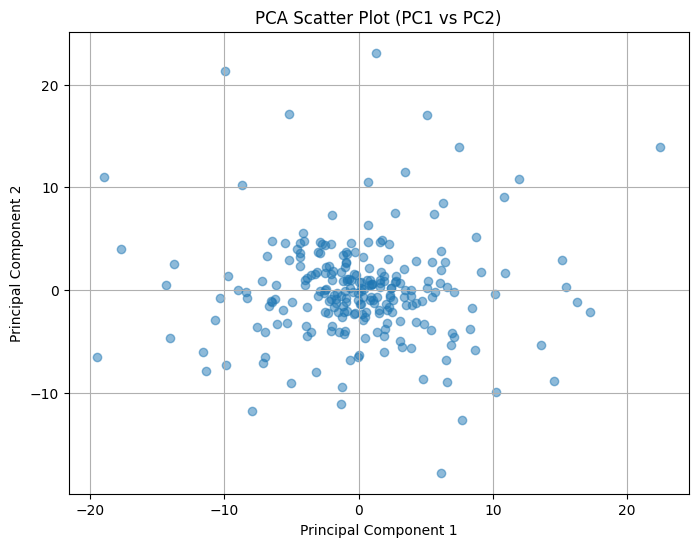

In [663]:
import matplotlib.pyplot as plt

# Project data onto the selected principal components
projected_data = np.dot(monthly_data_scaled, selected_components.T)

# Scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(projected_data[:, 0], projected_data[:, 1], alpha=0.5)
plt.title('PCA Scatter Plot (PC1 vs PC2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


In [664]:
monthly_data_scaled

array([[ 0.4237928 , -0.25924239,  1.18810553, ..., -0.05975973,
        -0.81842937,  0.93160021],
       [ 0.16022315, -0.45690916,  0.80707974, ...,  0.11922935,
        -0.50447668,  0.03778388],
       [ 1.24991103, -0.58108363,  0.73237733, ..., -0.27810699,
        -0.19052399, -0.10436574],
       ...,
       [-0.88980873, -0.10083386,  0.37525417, ...,  0.05725051,
         0.21994917,  0.1422544 ],
       [-0.66878797, -0.40543131,  0.79679904, ...,  0.08953073,
         0.10008705,  0.08823272],
       [-0.84214272, -0.73471895,  0.29714894, ...,  0.00479115,
         0.19431995, -0.03025829]])

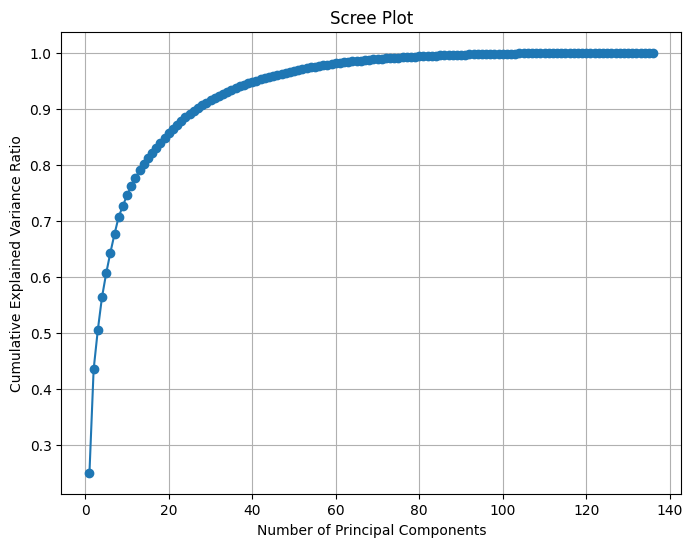

In [665]:
# Scree plot to visualize explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()


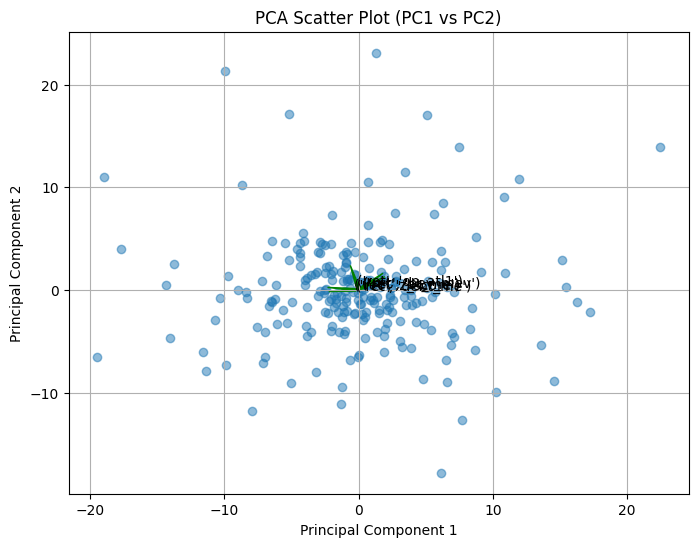

In [666]:
import matplotlib.pyplot as plt

# Project data onto the selected principal components
projected_data = np.dot(monthly_data_scaled, selected_components.T)

# Scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(projected_data[:, 0], projected_data[:, 1], alpha=0.5)
plt.title('PCA Scatter Plot (PC1 vs PC2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

# Add directional vectors indicating feature names
for i, feature in enumerate(top_features[0][:5]):  # Consider top 5 features for PC1
    plt.arrow(0, 0, selected_components[0, i]*3, selected_components[1, i]*3, color='g', width=0.1, head_width=0.2, head_length=2)
    plt.text(selected_components[0, i]*3, selected_components[1, i]*3, feature, color='black')


plt.show()


In [667]:
for component in selected_components:
    component_loadings = pd.Series(component, index=feature_names)
    top_features.append(list(component_loadings.abs().sort_values(ascending=False).index[:5]))  # Convert tuple to list


In [668]:

factors_data=df_cleaned
# Calculate correlation matrix to identify factors that are highly correlated with each other
correlation_matrix = factors_data.corr().abs()

# Set a threshold for correlation coefficient to identify highly correlated factors
threshold = 0.8  # Adjust threshold as needed

# Find pairs of factors with correlation coefficient above the threshold
correlated_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > threshold:
            correlated_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

# Identify potential amalgamated factors based on correlated pairs
potential_amalgamated_factors = set()
for factor1, factor2 in correlated_pairs:
    potential_amalgamated_factors.add(factor1)
    potential_amalgamated_factors.add(factor2)

# Print potential amalgamated factors
print("Potential Amalgamated Factors:")
print(potential_amalgamated_factors)

# Filter out potential amalgamated factors from factors_data
filtered_factors_data = factors_data.drop(columns=potential_amalgamated_factors)

data_col = list(filtered_factors_data.columns)
new_cols = []
for row in data_col:
    new_cols.append(row[1])
filtered_factors_data.columns = new_cols
filtered_factors_data.columns

# Display the filtered factors data
print("\nFiltered Factors Data:")
filtered_factors_data


Potential Amalgamated Factors:
{('ret', 'betabab_1260d'), ('ret', 'bev_mev'), ('ret', 'sale_gr3'), ('ret', 'market_equity'), ('ret', 'betadown_252d'), ('ret', 'beta_dimson_21d'), ('ret', 'op_at'), ('ret', 'at_gr1'), ('ret', 'ivol_ff3_21d'), ('ret', 'oaccruals_ni'), ('ret', 'seas_2_5na'), ('ret', 'zero_trades_126d'), ('ret', 'z_score'), ('ret', 'rmax5_21d'), ('ret', 'ami_126d'), ('ret', 'zero_trades_21d'), ('ret', 'at_me'), ('ret', 'ncoa_gr1a'), ('ret', 'gp_at'), ('ret', 'seas_1_1na'), ('ret', 'low_risk'), ('ret', 'noa_gr1a'), ('ret', 'div12m_me'), ('ret', 'sale_gr1'), ('ret', 'dolvol_126d'), ('ret', 'short_term_reversal'), ('ret', 'at_be'), ('ret', 'ocf_me'), ('ret', 'ret_9_1'), ('ret', 'qmj_safety'), ('ret', 'cop_at'), ('ret', 'dolvol_var_126d'), ('ret', 'qmj'), ('ret', 'mispricing_mgmt'), ('ret', 'ebitda_mev'), ('ret', 'prc_highprc_252d'), ('ret', 'debt_me'), ('ret', 'ope_bel1'), ('ret', 'momentum'), ('ret', 'beta_60m'), ('ret', 'dbnetis_at'), ('ret', 'rvol_21d'), ('ret', 'nncoa_gr1a

,age,aliq_at,aliq_mat,cash_at,chcsho_12m,coa_gr1a,col_gr1a,coskew_21d,cowc_gr1a,debt_gr3,...,rmax5_rvol_21d,rskew_21d,sale_emp_gr1,seas_1_1an,seas_2_5an,seasonality,sti_gr1a,taccruals_at,tangibility,tax_gr1a
1993-04-01,-0.002801,0.003551,0.000259,-0.005378,0.007163,-0.000475,-0.003795,-0.001073,0.001990,0.000427,...,-0.005485,-0.005086,0.001198,-0.007114,-0.000438,-0.002491,0.000478,0.005419,0.000750,0.002243
1993-06-01,-0.004332,0.002300,0.000647,-0.002599,0.000340,-0.000628,-0.001442,0.001495,0.000920,-0.000351,...,0.000442,0.000040,-0.000367,0.000774,0.000196,-0.000016,0.001114,-0.000693,0.000229,0.001008
1993-07-01,-0.005294,0.002054,0.000105,-0.001298,-0.000833,0.001564,0.001840,0.001125,-0.000065,0.000834,...,0.002093,0.001550,-0.002087,0.001630,0.002699,0.000080,0.001820,0.002618,0.000994,-0.000374
1993-09-01,-0.001577,-0.001110,-0.000283,0.000556,0.000161,-0.000735,-0.001401,0.000288,-0.000589,0.002194,...,-0.001985,-0.001443,0.000223,-0.000323,0.000089,0.000170,-0.000953,-0.001903,-0.001909,0.001103
1993-10-01,-0.002408,0.000342,-0.000187,0.000510,0.000545,0.000173,-0.000194,-0.002513,0.000609,0.000080,...,0.003633,0.000322,-0.001119,-0.002872,0.001057,-0.000478,0.000494,0.000682,0.002424,0.001336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,-0.002322,-0.001073,-0.001700,0.001616,0.002110,0.001113,0.000104,0.002630,-0.000547,0.002367,...,-0.001836,-0.002857,0.001203,-0.003313,0.001613,0.000406,-0.002239,-0.001966,-0.001386,0.002141
2023-08-01,0.000537,-0.000184,-0.001832,-0.000529,0.000398,-0.000248,-0.000902,-0.001713,-0.000109,0.002101,...,0.000399,-0.000550,0.003442,0.002313,-0.000233,-0.000088,0.001218,-0.000258,0.001167,0.002442
2023-09-01,-0.001573,0.000881,-0.002450,-0.000316,0.002241,0.002893,0.002870,-0.000213,0.000026,0.000499,...,0.000957,-0.000486,0.002285,0.000406,0.004168,0.000416,-0.001284,-0.000613,0.001688,0.002010
2023-11-01,-0.003933,0.002266,0.001692,-0.003594,0.001745,-0.001436,-0.000344,0.002869,0.000624,-0.000660,...,-0.003743,-0.002056,0.001792,0.001236,0.000870,0.000065,0.000555,-0.001328,-0.002690,0.001368


In [669]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.decomposition import PCA
 
pca = PCA()
pca.fit(filtered_factors_data)


PCA()

In [670]:
aexplained_variance_ratio = pca.explained_variance_ratio_
aselected_components = pca.components_[:5]
# aselected_components
# sum(aselected_components[0])
aexplained_variance_ratio


array([0.22620157, 0.10121306, 0.09507322, 0.06547586, 0.06199893,
       0.0469863 , 0.04140348, 0.04084993, 0.02804855, 0.02537453,
       0.02286594, 0.02044971, 0.01764224, 0.01670572, 0.0144355 ,
       0.01411542, 0.01232815, 0.01170475, 0.01141884, 0.00984399,
       0.00963168, 0.00835287, 0.00786809, 0.00755314, 0.00660578,
       0.00636396, 0.0055849 , 0.00520127, 0.00478656, 0.00436509,
       0.00404513, 0.00394455, 0.00374874, 0.00359694, 0.00339884,
       0.00321902, 0.00312624, 0.00304979, 0.00271222, 0.00258765,
       0.00237084, 0.00215507, 0.00205729, 0.00193803, 0.00165622,
       0.00154455, 0.00120854, 0.00100318, 0.00081139, 0.00066965,
       0.00042499, 0.00028211])

In [671]:
n_components = 5  # Example: Retain the first 3 principal components
aexplained_variance_ratio = pca.explained_variance_ratio_
aselected_components = pca.components_[:n_components]

# Step 5: Projection
aprojected_data = np.dot(filtered_factors_data, aselected_components.T)

# Optional: Create a DataFrame with the transformed data
projected_df = pd.DataFrame(data=aprojected_data, columns=[f'PC{i+1}' for i in range(n_components)])

# Print explained variance ratio
print("Explained Variance Ratio:", aexplained_variance_ratio)

Explained Variance Ratio: [0.22620157 0.10121306 0.09507322 0.06547586 0.06199893 0.0469863
 0.04140348 0.04084993 0.02804855 0.02537453 0.02286594 0.02044971
 0.01764224 0.01670572 0.0144355  0.01411542 0.01232815 0.01170475
 0.01141884 0.00984399 0.00963168 0.00835287 0.00786809 0.00755314
 0.00660578 0.00636396 0.0055849  0.00520127 0.00478656 0.00436509
 0.00404513 0.00394455 0.00374874 0.00359694 0.00339884 0.00321902
 0.00312624 0.00304979 0.00271222 0.00258765 0.00237084 0.00215507
 0.00205729 0.00193803 0.00165622 0.00154455 0.00120854 0.00100318
 0.00081139 0.00066965 0.00042499 0.00028211]


In [672]:
aselected_components

array([[-6.94763748e-01,  2.46465666e-01, -1.81986230e-01,
        -1.93208946e-01,  1.10862587e-01,  1.65338288e-01,
         1.47680723e-01, -2.24550524e-02,  6.65509737e-02,
         4.99785811e-02,  1.56738099e-02, -6.66190205e-02,
        -2.49854415e-02,  1.40020709e-02, -9.48398331e-02,
        -5.10029107e-02,  2.06794904e-01,  2.40160055e-01,
        -2.83222620e-03,  2.95980305e-02,  4.18592080e-02,
         1.49201440e-01,  1.28810863e-01,  5.48542036e-02,
         2.95799333e-02,  2.56307760e-02,  2.04547653e-02,
         4.84135723e-02, -1.93536381e-02,  1.41265517e-04,
         4.85682965e-02,  1.33983994e-01,  1.11192119e-01,
        -5.52265171e-02, -2.85511155e-02, -7.53603011e-02,
         1.21848379e-01, -2.09914638e-01, -3.53148858e-02,
        -7.87918055e-03, -1.08327218e-01, -2.82083179e-02,
         3.57309376e-02,  1.66848523e-02, -6.80378135e-02,
        -4.02530139e-02, -7.58095165e-02, -1.00537740e-03,
        -7.72981188e-02,  4.91554254e-02,  1.95723601e-0

In [673]:
# Step 5: Get names of features with highest loadings for each principal component
afeature_names = filtered_factors_data.columns
atop_features = []
atop_featurez = []
for acomponent in aselected_components:
    acomponent_loadings = pd.Series(acomponent, index=afeature_names)
    # atop_features.append([acomponent_loadings.abs().sort_values(ascending=False).index[:5], acomponent_loadings.abs().sort_values(ascending=False)[:5]])  # Get top 5 features with highest loadings
    atop_features.append(acomponent_loadings.abs().sort_values(ascending=False)[:5])  # Get top 5 features with highest loadings
    atop_featurez.append(acomponent_loadings.abs().sort_values(ascending=False)[:5])  

atop_featurez

ffeature_names = [series.index.tolist() for series in atop_features]
ffeature_names = [item for sublist in ffeature_names for item in sublist]
ffeature_names = list(set(ffeature_names))
ffeature_names

['prc',
 'seas_1_1an',
 'emp_gr1',
 'rd_me',
 'resff3_6_1',
 'eqnpo_12m',
 'rd_sale',
 'aliq_at',
 'ret_12_7',
 'ret_3_1',
 'age',
 'rmax5_rvol_21d']

In [674]:
filtered_factors_data

,age,aliq_at,aliq_mat,cash_at,chcsho_12m,coa_gr1a,col_gr1a,coskew_21d,cowc_gr1a,debt_gr3,...,rmax5_rvol_21d,rskew_21d,sale_emp_gr1,seas_1_1an,seas_2_5an,seasonality,sti_gr1a,taccruals_at,tangibility,tax_gr1a
1993-04-01,-0.002801,0.003551,0.000259,-0.005378,0.007163,-0.000475,-0.003795,-0.001073,0.001990,0.000427,...,-0.005485,-0.005086,0.001198,-0.007114,-0.000438,-0.002491,0.000478,0.005419,0.000750,0.002243
1993-06-01,-0.004332,0.002300,0.000647,-0.002599,0.000340,-0.000628,-0.001442,0.001495,0.000920,-0.000351,...,0.000442,0.000040,-0.000367,0.000774,0.000196,-0.000016,0.001114,-0.000693,0.000229,0.001008
1993-07-01,-0.005294,0.002054,0.000105,-0.001298,-0.000833,0.001564,0.001840,0.001125,-0.000065,0.000834,...,0.002093,0.001550,-0.002087,0.001630,0.002699,0.000080,0.001820,0.002618,0.000994,-0.000374
1993-09-01,-0.001577,-0.001110,-0.000283,0.000556,0.000161,-0.000735,-0.001401,0.000288,-0.000589,0.002194,...,-0.001985,-0.001443,0.000223,-0.000323,0.000089,0.000170,-0.000953,-0.001903,-0.001909,0.001103
1993-10-01,-0.002408,0.000342,-0.000187,0.000510,0.000545,0.000173,-0.000194,-0.002513,0.000609,0.000080,...,0.003633,0.000322,-0.001119,-0.002872,0.001057,-0.000478,0.000494,0.000682,0.002424,0.001336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,-0.002322,-0.001073,-0.001700,0.001616,0.002110,0.001113,0.000104,0.002630,-0.000547,0.002367,...,-0.001836,-0.002857,0.001203,-0.003313,0.001613,0.000406,-0.002239,-0.001966,-0.001386,0.002141
2023-08-01,0.000537,-0.000184,-0.001832,-0.000529,0.000398,-0.000248,-0.000902,-0.001713,-0.000109,0.002101,...,0.000399,-0.000550,0.003442,0.002313,-0.000233,-0.000088,0.001218,-0.000258,0.001167,0.002442
2023-09-01,-0.001573,0.000881,-0.002450,-0.000316,0.002241,0.002893,0.002870,-0.000213,0.000026,0.000499,...,0.000957,-0.000486,0.002285,0.000406,0.004168,0.000416,-0.001284,-0.000613,0.001688,0.002010
2023-11-01,-0.003933,0.002266,0.001692,-0.003594,0.001745,-0.001436,-0.000344,0.002869,0.000624,-0.000660,...,-0.003743,-0.002056,0.001792,0.001236,0.000870,0.000065,0.000555,-0.001328,-0.002690,0.001368


In [675]:
factor_world_weighting_monthly.to_csv("hellpo",index=False)

In [676]:
pivot_df = factor_world_weighting_monthly.pivot(index='date', columns='factors', values='ret')

In [677]:
factor_world_weighting_monthly['date'] = pd.to_datetime(factor_world_weighting_monthly['date'])

In [678]:
atop_features

[age          0.694764
 aliq_at      0.246466
 eqnpo_12m    0.240160
 rd_sale      0.209915
 emp_gr1      0.206795
 dtype: float64,
 ret_3_1           0.616115
 age               0.378338
 rmax5_rvol_21d    0.302573
 resff3_6_1        0.240828
 rd_sale           0.208130
 dtype: float64,
 age         0.491242
 ret_12_7    0.329956
 ret_3_1     0.308696
 prc         0.300302
 rd_me       0.269259
 dtype: float64,
 ret_12_7      0.542300
 ret_3_1       0.329817
 rd_sale       0.298768
 age           0.286054
 seas_1_1an    0.234908
 dtype: float64,
 rd_sale           0.481295
 rd_me             0.436292
 ret_12_7          0.353958
 rmax5_rvol_21d    0.301344
 seas_1_1an        0.201779
 dtype: float64]

In [679]:
filtered_factors_data11=pca.fit_transform(filtered_factors_data)

In [680]:
new_dataset = filtered_factors_data[ffeature_names]

In [681]:
new_dataset

,prc,seas_1_1an,emp_gr1,rd_me,resff3_6_1,eqnpo_12m,rd_sale,aliq_at,ret_12_7,ret_3_1,age,rmax5_rvol_21d
1993-04-01,0.001475,-0.007114,0.002647,-0.005076,-0.004049,0.003810,-0.008717,0.003551,0.002444,0.007221,-0.002801,-0.005485
1993-06-01,0.001577,0.000774,-0.001334,-0.001603,-0.001521,0.001707,-0.002342,0.002300,0.001290,-0.000719,-0.004332,0.000442
1993-07-01,0.000755,0.001630,-0.000642,-0.000253,-0.000945,0.000323,0.000190,0.002054,0.002212,-0.000924,-0.005294,0.002093
1993-09-01,-0.004074,-0.000323,-0.001798,0.001096,0.002021,0.000261,0.002721,-0.001110,-0.000768,-0.001339,-0.001577,-0.001985
1993-10-01,0.001583,-0.002872,-0.000404,0.002208,-0.001143,-0.001124,0.002692,0.000342,-0.000693,0.001527,-0.002408,0.003633
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,-0.000008,-0.003313,0.000774,-0.000731,-0.000746,-0.000628,0.000182,-0.001073,-0.000547,-0.000516,-0.002322,-0.001836
2023-08-01,-0.001004,0.002313,0.001874,0.002432,0.004332,0.001614,0.001751,-0.000184,0.000224,0.003992,0.000537,0.000399
2023-09-01,0.000993,0.000406,0.000717,-0.001759,-0.001471,0.003479,-0.004499,0.000881,0.000376,0.002969,-0.001573,0.000957
2023-11-01,-0.001875,0.001236,0.002119,-0.000250,0.001581,0.001778,0.003721,0.002266,0.001044,0.002831,-0.003933,-0.003743


In [682]:
# Disable SSL certificate verification
requests.packages.urllib3.disable_warnings()

# Fetch HTML content
response = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', verify=False)
html_content = response.content

# Read HTML content into pandas DataFrame
list_of_dfs = pd.read_html(html_content)
wikitable_sp_500 = list_of_dfs[0]
sp500_symbols = wikitable_sp_500['Symbol']
#Converting SP_500 tickers into list 
tickers = sp500_symbols.to_list()
#Remove some tickers as they create an error for the yfinance api
tickers[65] = 'BRK-B'
tickers[81] = 'BF-B'
tickers.remove('BF-B')
tickers.remove('BRK-B')
#Start Date for In Sample Historical Data
start = '2020-03-01'

#End Date for In Sample Historical Data
end   = '2022-12-31'
#Monthly Returns for Stocks in the List
monthly_data = yf.download(tickers,start=start,end=end,interval='1mo')
#Reformat Date Index 
monthly_data.index = pd.to_datetime(monthly_data.index)
monthly_data = monthly_data.tz_localize(None)
#Turn Adj Close prices into pct returns
monthly_data = monthly_data['Adj Close'].pct_change()
#Drop First row NaN values
monthly_data = monthly_data.drop(monthly_data.index[0])
#Drop if stock doesnt have data starting from the first index date
monthly_data = monthly_data.dropna(axis=1)
#Assign equal weight as base weights
base_w = {k: 1/len(monthly_data.columns) for k in monthly_data.columns}
base_w = pd.DataFrame.from_dict(base_w, orient='index', columns=['Weight'])
#Getting SP_500 data
spy = pd.DataFrame(yf.download('^GSPC',start=start,end=end,interval='1mo')['Adj Close'].pct_change())
#Dropping First Row(NaN) and formatting index to match monthly_data 
spy = spy.drop(spy.index[0]).tz_localize(None)
#Adding SP_500 data to monthly_data
monthly_data['SP_500'] = spy['Adj Close']

[*********************100%%**********************]  501 of 501 completed

7 Failed downloads:
['KVUE', 'GEV', 'SOLV', 'VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1583038800, endDate = 1672462800")
['BF.B', 'GEHC']: Exception('%ticker%: No price data found, symbol may be delisted (1mo 2020-03-01 -> 2022-12-31)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed


In [683]:
monthly_data



Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS,SP_500
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-01,0.073096,-0.014766,0.155373,0.078882,0.167025,-0.155657,0.134326,0.111237,0.222532,0.055713,...,0.305928,0.421000,0.060890,0.223861,0.103946,0.261200,0.187153,0.250871,0.098734,0.126844
2020-05-01,0.149752,-0.125729,0.082165,0.144186,0.035071,0.174365,0.093632,0.093202,0.030566,0.058428,...,-0.076818,-0.026307,0.023128,-0.021519,-0.077330,0.038181,0.055472,0.137856,0.079696,0.045282
2020-06-01,0.002610,0.244762,0.150492,0.059458,-0.036768,0.015237,0.064974,0.125996,0.091692,0.025319,...,0.112432,-0.105547,-0.038905,0.002575,-0.016885,-0.026357,-0.055248,-0.020550,-0.016859,0.018388
2020-07-01,0.092365,-0.149197,0.165132,-0.033306,0.100733,0.073298,0.046852,0.020698,-0.063519,0.073434,...,0.238201,-0.027655,0.111987,-0.059034,0.123461,0.047635,0.132216,0.096894,0.106830,0.055101
2020-08-01,0.042458,0.173561,0.214380,0.021377,0.091961,0.025691,0.071310,0.155451,0.017675,0.045062,...,0.089896,0.207373,0.006228,-0.050856,0.098657,0.052718,0.044639,0.020588,0.056991,0.070065
2020-09-01,0.005178,-0.058238,-0.100908,-0.085413,-0.005846,-0.072606,-0.058100,-0.044722,0.003967,0.047143,...,-0.059057,-0.178845,-0.006621,-0.123504,0.052521,-0.042811,-0.033646,-0.118905,0.032917,-0.039228
2020-10-01,0.011393,-0.082181,-0.060012,-0.028428,-0.034182,0.032820,-0.040179,-0.088351,0.015333,-0.005378,...,-0.043128,0.008634,0.021157,-0.049811,0.035901,0.022234,-0.027964,0.123505,-0.041241,-0.027666
2020-11-01,0.147133,0.252660,0.093607,0.245642,0.033020,0.065872,0.152853,0.070163,0.173373,0.076341,...,0.064126,0.387547,-0.038127,0.168915,0.101331,0.133612,0.128842,0.334156,0.012808,0.107546
2020-12-01,0.013601,0.116065,0.116497,0.024574,0.011735,0.120186,0.048657,0.045248,0.062195,0.020181,...,0.154615,0.122687,-0.010243,0.107120,0.063663,0.030700,0.033329,0.015617,0.031924,0.037121


In [684]:
#Adjusting tickers list as some tickers will not be included in the monthly_data if there is no data for test date range
tickers = list(monthly_data.columns[:-1])
tick_index = tickers + ['SP_500']

In [685]:

atickers=list(monthly_data.columns)
atickers.remove('SP_500')
atickers

['A',
 'AAL',
 'AAPL',
 'ABBV',
 'ABT',
 'ACGL',
 'ACN',
 'ADBE',
 'ADI',
 'ADM',
 'ADP',
 'ADSK',
 'AEE',
 'AEP',
 'AES',
 'AFL',
 'AIG',
 'AIZ',
 'AJG',
 'AKAM',
 'ALB',
 'ALGN',
 'ALL',
 'ALLE',
 'AMAT',
 'AMCR',
 'AMD',
 'AME',
 'AMGN',
 'AMP',
 'AMT',
 'AMZN',
 'ANET',
 'ANSS',
 'AON',
 'AOS',
 'APA',
 'APD',
 'APH',
 'APTV',
 'ARE',
 'ATO',
 'AVB',
 'AVGO',
 'AVY',
 'AWK',
 'AXON',
 'AXP',
 'AZO',
 'BA',
 'BAC',
 'BALL',
 'BAX',
 'BBWI',
 'BBY',
 'BDX',
 'BEN',
 'BG',
 'BIIB',
 'BIO',
 'BK',
 'BKNG',
 'BKR',
 'BLDR',
 'BLK',
 'BMY',
 'BR',
 'BRO',
 'BSX',
 'BWA',
 'BX',
 'BXP',
 'C',
 'CAG',
 'CAH',
 'CAT',
 'CB',
 'CBOE',
 'CBRE',
 'CCI',
 'CCL',
 'CDW',
 'CE',
 'CF',
 'CFG',
 'CHD',
 'CHRW',
 'CHTR',
 'CI',
 'CINF',
 'CL',
 'CLX',
 'CMA',
 'CMCSA',
 'CME',
 'CMG',
 'CMI',
 'CMS',
 'CNC',
 'CNP',
 'COF',
 'COO',
 'COP',
 'COR',
 'COST',
 'CPAY',
 'CPB',
 'CPRT',
 'CPT',
 'CRL',
 'CRM',
 'CSCO',
 'CSGP',
 'CSX',
 'CTAS',
 'CTLT',
 'CTRA',
 'CTSH',
 'CTVA',
 'CVS',
 'CVX',
 'CZR',

In [686]:
common_index_dates = monthly_data.index.intersection(new_dataset.index)
common_index_dates
new_monthly_data = monthly_data.loc[common_index_dates]

In [687]:
new_dataset = new_dataset.loc[common_index_dates]
new_dataset

,prc,seas_1_1an,emp_gr1,rd_me,resff3_6_1,eqnpo_12m,rd_sale,aliq_at,ret_12_7,ret_3_1,age,rmax5_rvol_21d
2020-04-01,-0.001431,-0.011087,-0.001428,-0.009364,-0.001750,-0.005262,-0.000284,0.000148,-0.000578,0.006839,0.018360,0.008936
2020-05-01,-0.003762,0.011330,-0.001903,-0.016066,0.006198,-0.008599,-0.006638,-0.006273,0.009309,0.021268,0.011789,0.008149
2020-06-01,0.001722,0.002559,-0.001393,0.001190,-0.001212,0.001025,0.002001,-0.006101,-0.000014,-0.007420,0.005427,-0.001240
2020-07-01,-0.003141,0.003917,-0.004548,-0.005422,0.000574,-0.004302,0.000131,0.000351,0.002954,0.002802,0.008300,0.004806
2020-09-01,-0.003956,-0.001661,-0.002869,0.000483,0.004528,-0.003597,0.002332,-0.004042,0.001367,0.007225,0.010094,-0.000500
2020-10-01,-0.004338,0.003663,-0.002990,-0.002073,0.002593,-0.001917,0.003963,-0.004151,0.008586,0.007927,0.004598,-0.006038
2020-12-01,0.006401,0.002421,0.004067,0.005104,0.001192,-0.000399,-0.002797,-0.002976,-0.012945,-0.003474,-0.004065,-0.004887
2021-02-01,-0.002915,0.000513,-0.004689,-0.000868,0.001474,-0.005251,0.007993,-0.006469,0.007549,0.002255,0.010729,-0.003646
2021-03-01,-0.004314,-0.004082,-0.003955,0.001122,0.003691,-0.002196,0.006024,-0.004394,0.002446,0.005482,0.000235,-0.000412
2021-04-01,-0.004599,0.010298,-0.007640,-0.004461,0.000833,-0.009868,0.009986,-0.013171,0.013453,-0.001756,0.014081,0.000144


In [688]:
new_monthly_data

Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS,SP_500
2020-04-01,0.073096,-0.014766,0.155373,0.078882,0.167025,-0.155657,0.134326,0.111237,0.222532,0.055713,...,0.305928,0.421000,0.060890,0.223861,0.103946,0.261200,0.187153,0.250871,0.098734,0.126844
2020-05-01,0.149752,-0.125729,0.082165,0.144186,0.035071,0.174365,0.093632,0.093202,0.030566,0.058428,...,-0.076818,-0.026307,0.023128,-0.021519,-0.077330,0.038181,0.055472,0.137856,0.079696,0.045282
2020-06-01,0.002610,0.244762,0.150492,0.059458,-0.036768,0.015237,0.064974,0.125996,0.091692,0.025319,...,0.112432,-0.105547,-0.038905,0.002575,-0.016885,-0.026357,-0.055248,-0.020550,-0.016859,0.018388
2020-07-01,0.092365,-0.149197,0.165132,-0.033306,0.100733,0.073298,0.046852,0.020698,-0.063519,0.073434,...,0.238201,-0.027655,0.111987,-0.059034,0.123461,0.047635,0.132216,0.096894,0.106830,0.055101
2020-09-01,0.005178,-0.058238,-0.100908,-0.085413,-0.005846,-0.072606,-0.058100,-0.044722,0.003967,0.047143,...,-0.059057,-0.178845,-0.006621,-0.123504,0.052521,-0.042811,-0.033646,-0.118905,0.032917,-0.039228
2020-10-01,0.011393,-0.082181,-0.060012,-0.028428,-0.034182,0.032820,-0.040179,-0.088351,0.015333,-0.005378,...,-0.043128,0.008634,0.021157,-0.049811,0.035901,0.022234,-0.027964,0.123505,-0.041241,-0.027666
2020-12-01,0.013601,0.116065,0.116497,0.024574,0.011735,0.120186,0.048657,0.045248,0.062195,0.020181,...,0.154615,0.122687,-0.010243,0.107120,0.063663,0.030700,0.033329,0.015617,0.031924,0.037121
2021-02-01,0.017477,0.219569,-0.081085,0.063623,-0.026923,0.140401,0.040664,0.001962,0.057626,0.131374,...,0.085925,0.323521,-0.084388,0.212533,0.030749,0.020101,0.061105,0.287755,0.007978,0.026091
2021-03-01,0.041533,0.141356,0.008845,0.004455,0.000501,0.071189,0.101036,0.034155,-0.000486,0.014465,...,0.051078,-0.048280,0.135177,0.044292,0.059445,0.049923,-0.018275,-0.028533,0.014429,0.042439
2021-04-01,0.051125,-0.091213,0.076218,0.030309,0.002003,0.034923,0.049665,0.069357,-0.012380,0.107544,...,0.094595,0.024168,0.080015,0.025255,0.052006,0.104825,0.108381,0.005276,0.098743,0.052425


In [689]:
SP_monthly_data=new_monthly_data.iloc[:, -1:]
SP_monthly_data


Ticker,SP_500
2020-04-01,0.126844
2020-05-01,0.045282
2020-06-01,0.018388
2020-07-01,0.055101
2020-09-01,-0.039228
2020-10-01,-0.027666
2020-12-01,0.037121
2021-02-01,0.026091
2021-03-01,0.042439
2021-04-01,0.052425


In [690]:
new_dataset.corr()

,prc,seas_1_1an,emp_gr1,rd_me,resff3_6_1,eqnpo_12m,rd_sale,aliq_at,ret_12_7,ret_3_1,age,rmax5_rvol_21d
prc,1.000000,-0.110973,0.792517,0.525445,-0.059403,0.596331,-0.554562,0.381043,-0.512279,-0.266910,-0.692524,0.070990
seas_1_1an,-0.110973,1.000000,0.007144,-0.248780,0.493218,-0.156003,-0.053912,-0.437196,0.572083,0.255706,0.059027,-0.016907
emp_gr1,0.792517,0.007144,1.000000,0.472128,0.275935,0.798390,-0.621534,0.518144,-0.152648,0.145506,-0.785313,0.334943
rd_me,0.525445,-0.248780,0.472128,1.000000,-0.094464,0.652111,0.195845,0.259219,-0.417219,-0.483392,-0.742782,-0.332879
resff3_6_1,-0.059403,0.493218,0.275935,-0.094464,1.000000,0.120133,-0.171468,-0.292657,0.419977,0.725021,-0.086489,0.207487
eqnpo_12m,0.596331,-0.156003,0.798390,0.652111,0.120133,1.000000,-0.358432,0.563475,-0.130676,-0.037679,-0.785584,0.164306
rd_sale,-0.554562,-0.053912,-0.621534,0.195845,-0.171468,-0.358432,1.000000,-0.481781,0.172869,-0.346686,0.324404,-0.502444
aliq_at,0.381043,-0.437196,0.518144,0.259219,-0.292657,0.563475,-0.481781,1.000000,-0.375074,-0.117845,-0.489135,0.115506
ret_12_7,-0.512279,0.572083,-0.152648,-0.417219,0.419977,-0.130676,0.172869,-0.375074,1.000000,0.458487,0.329798,0.304440
ret_3_1,-0.266910,0.255706,0.145506,-0.483392,0.725021,-0.037679,-0.346686,-0.117845,0.458487,1.000000,0.090352,0.514196


In [691]:
new_dataset.describe()

,prc,seas_1_1an,emp_gr1,rd_me,resff3_6_1,eqnpo_12m,rd_sale,aliq_at,ret_12_7,ret_3_1,age,rmax5_rvol_21d
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,-0.000563,0.000662,-0.000631,-0.000910,0.000604,-0.002011,0.001038,-0.001615,0.001390,0.001325,0.003587,0.000607
std,0.003129,0.004767,0.004323,0.004917,0.002714,0.004427,0.004003,0.004156,0.005896,0.006239,0.007358,0.004193
min,-0.005675,-0.011087,-0.007684,-0.016066,-0.004572,-0.009868,-0.006638,-0.013171,-0.012945,-0.007420,-0.009619,-0.009422
25%,-0.003141,-0.001808,-0.003535,-0.002742,-0.001212,-0.004302,-0.000976,-0.004193,-0.000578,-0.002920,-0.003029,-0.001240
50%,0.000415,0.000100,-0.001393,0.000240,0.000650,-0.002213,0.001027,-0.001522,0.001367,0.002010,0.002951,0.000160
75%,0.001759,0.003219,0.003331,0.001035,0.002593,0.000572,0.002394,0.001860,0.004407,0.004067,0.008300,0.002507
max,0.006401,0.011330,0.007381,0.007090,0.006198,0.007466,0.009986,0.006435,0.013453,0.021268,0.018360,0.008936


In [692]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
# Create an empty DataFrame to store the Stock Betas
stock_betas = pd.DataFrame()

# Iterate over the tickers list
for col in new_monthly_data.columns:
    # Set the dependent variable (Return of stock i)
    y = new_monthly_data[col]
    
    # Set the independent variables (Fama French 3 Factors)
    X = new_dataset[['ret_3_1','ret_12_7','seas_1_1an','prc','eqnpo_12m','rd_me','age','resff3_6_1','rmax5_rvol_21d','aliq_at','emp_gr1','rd_sale']]
    
    # Fit the multiple linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Store the results in the DataFrame
    stock_betas[col] = [model.intercept_] + list(model.coef_)
stock_betas = stock_betas.T
stock_betas.columns = ['Intercept','ret_3_1','ret_12_7','seas_1_1an','prc','eqnpo_12m','rd_me','age','resff3_6_1','rmax5_rvol_21d','aliq_at','emp_gr1','rd_sale']

In [693]:
stock_betas.loc['AAPL']

Intercept          0.005926
ret_3_1            8.898789
ret_12_7           1.407139
seas_1_1an        12.095609
prc               31.092990
eqnpo_12m          1.970015
rd_me             11.358456
age                8.723263
resff3_6_1       -21.092049
rmax5_rvol_21d    10.983889
aliq_at            5.981295
emp_gr1          -16.579730
rd_sale            0.381894
Name: AAPL, dtype: float64

In [694]:
stock_betas.describe()

,Intercept,ret_3_1,ret_12_7,seas_1_1an,prc,eqnpo_12m,rd_me,age,resff3_6_1,rmax5_rvol_21d,aliq_at,emp_gr1,rd_sale
count,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000
mean,-0.007280,3.911182,6.278569,-3.398140,15.947077,-7.857453,8.885515,4.173691,-5.791027,3.048123,0.197896,-7.546455,-4.706083
std,0.024309,7.394560,5.909232,5.970333,17.712950,8.510375,11.191129,7.402484,14.606534,6.965181,8.351537,17.416408,12.275967
min,-0.134929,-17.062680,-14.577413,-28.867098,-44.106960,-39.461532,-59.256053,-13.580599,-76.961931,-20.985069,-26.644535,-91.449198,-48.329924
25%,-0.020698,-1.388936,2.968359,-7.204335,4.927636,-12.783838,2.098675,-0.389746,-12.893849,-1.468128,-4.067505,-18.210030,-11.632533
50%,-0.004700,3.377130,6.233922,-3.657803,15.616948,-7.588672,8.757945,3.181152,-4.407698,3.628699,0.195601,-8.989993,-4.759000
75%,0.008435,8.180820,9.678754,0.244927,26.530729,-2.728543,15.806490,7.405499,4.331383,7.821411,4.450904,0.538510,2.063662
max,0.071699,33.430009,36.763011,16.426164,86.051963,23.102160,39.664692,60.438444,28.588109,24.714174,32.803951,92.356398,103.352730


In [695]:
import getFamaFrenchFactors as gff

In [696]:
# Fama French Monthly Returns Data using getFamaFrenchFactors module
ff3_monthly = gff.famaFrench3Factor(frequency='m')
ff3_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)
ff3_monthly.index = ff3_monthly.index.to_period('M').to_timestamp('D')
# Keeping Only the Dates in the monthly_data
ff3_monthly = ff3_monthly.loc[new_monthly_data.index]
ff3_monthly

,Mkt-RF,SMB,HML,RF
2020-04-01,0.1365,0.0245,-0.0133,0.0000
2020-05-01,0.0558,0.0247,-0.0488,0.0001
2020-06-01,0.0246,0.0269,-0.0220,0.0001
2020-07-01,0.0577,-0.0233,-0.0141,0.0001
2020-09-01,-0.0363,0.0002,-0.0271,0.0001
2020-10-01,-0.0210,0.0438,0.0425,0.0001
2020-12-01,0.0463,0.0489,-0.0151,0.0001
2021-02-01,0.0278,0.0205,0.0715,0.0000
2021-03-01,0.0308,-0.0237,0.0739,0.0000
2021-04-01,0.0493,-0.0319,-0.0095,0.0000


In [697]:
#Stock Prices on the Day of Optimization(Rebalancing)
stock_price = pd.DataFrame(yf.download(tickers,start=start,end=end,interval='1d')['Adj Close'])
stock_price = stock_price[-1:]
stock_price.index = pd.to_datetime(stock_price.index).tz_localize(None)

s_price = {}
s_keys = list(tickers)
s_values =  list(stock_price.iloc[0])
for key,value in zip(s_keys,s_values):
    s_price[key] = value

[*********************100%%**********************]  490 of 490 completed


In [698]:
print(s_price)

{'A': 148.32952880859375, 'AAL': 12.720000267028809, 'AAPL': 128.86831665039062, 'ABBV': 152.44105529785156, 'ABT': 106.59061431884766, 'ACGL': 62.779998779296875, 'ACN': 260.70172119140625, 'ADBE': 336.5299987792969, 'ADI': 160.20974731445312, 'ADM': 89.89907836914062, 'ADP': 232.21043395996094, 'ADSK': 186.8699951171875, 'AEE': 85.40174102783203, 'AEP': 90.19584655761719, 'AES': 27.29753875732422, 'AFL': 69.85193634033203, 'AIG': 61.416255950927734, 'AIZ': 122.00322723388672, 'AJG': 186.14903259277344, 'AKAM': 84.30000305175781, 'ALB': 214.30599975585938, 'ALGN': 210.89999389648438, 'ALL': 130.83888244628906, 'ALLE': 103.2015609741211, 'AMAT': 96.32246398925781, 'AMCR': 11.180301666259766, 'AMD': 64.7699966430664, 'AME': 138.57296752929688, 'AMGN': 251.87290954589844, 'AMP': 304.2038879394531, 'AMT': 203.05203247070312, 'AMZN': 84.0, 'ANET': 121.3499984741211, 'ANSS': 241.58999633789062, 'AON': 296.5604553222656, 'AOS': 55.769432067871094, 'APA': 44.835140228271484, 'APD': 298.534149

In [699]:
#Transaction Costs
random.seed(1)
t_cost = {}
keys       = list(tickers)
#values     = [.15 for i in range(len(keys))]
values = list(random.uniform(.009,.021) for i in range(len(tickers)))
for key,value in zip(keys,values):
    t_cost[key] = value

In [700]:
t_cost

{'A': 0.010612370929348814,
 'AAL': 0.019169204843246794,
 'AAPL': 0.01816529542771937,
 'ABBV': 0.01206082830887306,
 'ABT': 0.01494522104510329,
 'ACGL': 0.014393892777464858,
 'ACN': 0.016819115672673156,
 'ADBE': 0.01846468021362616,
 'ADI': 0.010126315041290818,
 'ADM': 0.009340169718264076,
 'ADP': 0.019029181247038437,
 'ADSK': 0.014193204814860642,
 'AEE': 0.018147360989495306,
 'AEP': 0.009025272640213328,
 'AES': 0.014344646328657618,
 'AFL': 0.01765848038808939,
 'AIG': 0.011745146655245432,
 'AIZ': 0.020343248346647066,
 'AJG': 0.019817129491337807,
 'AKAM': 0.009367079796402642,
 'ALB': 0.009305350331921529,
 'ALGN': 0.01549694967352196,
 'ALL': 0.020269789953342127,
 'ALLE': 0.01357445085225855,
 'AMAT': 0.01159919276556736,
 'AMCR': 0.014065398906992608,
 'AMD': 0.009348489450898414,
 'AME': 0.01166029999527642,
 'AMGN': 0.014254651123806864,
 'AMP': 0.014949746896582208,
 'AMT': 0.011797013403090872,
 'AMZN': 0.011770398498491812,
 'ANET': 0.011625372448052264,
 'ANSS':

In [701]:
s_p_500_betas=stock_betas.iloc[-1,1:]
s_p_500_betas

ret_3_1            2.211865
ret_12_7           5.388019
seas_1_1an        -1.601758
prc               15.712976
eqnpo_12m         -6.814309
rd_me              7.680539
age                3.866359
resff3_6_1        -4.493307
rmax5_rvol_21d     4.423794
aliq_at            1.740904
emp_gr1           -7.881054
rd_sale           -3.548225
Name: SP_500, dtype: float64

In [702]:
Target={}
Target["prc"] = -0.248                       
Target["seas_1_1an"] = -2.224                           
Target["emp_gr1"] = 1.006                          
Target["rd_me"] = 0.370                          
Target["resff3_6_1"] = -0.477                          
Target["eqnpo_12m"] = -1.510
Target["rd_sale"] = 0.215
Target["aliq_at"] = -1.098                           
Target["ret_12_7"] = 0.323                          
Target["ret_3_1"] = -0.659                          
Target["age"] = 1.740                          
Target["rmax5_rvol_21d"] = 1.031
budget = 1000000                             
maxstocks = 100                                
base_weights = base_w.T*0   
max_trcost=10000

In [703]:
nah=new_monthly_data.T[:-1]

nahh=nah.T
weight

{'A': Weight_A,
 'AAL': Weight_AAL,
 'AAPL': Weight_AAPL,
 'ABBV': Weight_ABBV,
 'ABT': Weight_ABT,
 'ACGL': Weight_ACGL,
 'ACN': Weight_ACN,
 'ADBE': Weight_ADBE,
 'ADI': Weight_ADI,
 'ADM': Weight_ADM,
 'ADP': Weight_ADP,
 'ADSK': Weight_ADSK,
 'AEE': Weight_AEE,
 'AEP': Weight_AEP,
 'AES': Weight_AES,
 'AFL': Weight_AFL,
 'AIG': Weight_AIG,
 'AIZ': Weight_AIZ,
 'AJG': Weight_AJG,
 'AKAM': Weight_AKAM,
 'ALB': Weight_ALB,
 'ALGN': Weight_ALGN,
 'ALL': Weight_ALL,
 'ALLE': Weight_ALLE,
 'AMAT': Weight_AMAT,
 'AMCR': Weight_AMCR,
 'AMD': Weight_AMD,
 'AME': Weight_AME,
 'AMGN': Weight_AMGN,
 'AMP': Weight_AMP,
 'AMT': Weight_AMT,
 'AMZN': Weight_AMZN,
 'ANET': Weight_ANET,
 'ANSS': Weight_ANSS,
 'AON': Weight_AON,
 'AOS': Weight_AOS,
 'APA': Weight_APA,
 'APD': Weight_APD,
 'APH': Weight_APH,
 'APTV': Weight_APTV,
 'ARE': Weight_ARE,
 'ATO': Weight_ATO,
 'AVB': Weight_AVB,
 'AVGO': Weight_AVGO,
 'AVY': Weight_AVY,
 'AWK': Weight_AWK,
 'AXON': Weight_AXON,
 'AXP': Weight_AXP,
 'AZO': We

In [708]:
from pulp import LpVariable, LpMinimize, LpProblem, lpSum



# Create LP problem
prob = LpProblem("Factor_Decay_Model", LpMinimize)

# Variables
aux = {i: LpVariable(f"Aux_{i}", lowBound=0) for i in tickers} # Absolute value of change for stock i from base weights
weight = {i: LpVariable(f"Weight_{i}", lowBound=0) for i in tickers}
error = {t: LpVariable(f"Error_{t}", lowBound=0) for t in new_monthly_data.index}
shares = {i: LpVariable(f"Shares_{i}", lowBound=0) for i in tickers}
trcost = {i: LpVariable(f"TrCost_{i}", lowBound=0) for i in tickers}
b = {i: LpVariable(f"B_{i}", cat='Binary') for i in tickers}

# Objective
prob += lpSum(error[t] for t in new_monthly_data.index)


# Constraints
prob += lpSum(weight[i] for i in tickers) == 1
for i in tickers:
    prob += aux[i] <= base_weights[i] - weight[i]
    prob += aux[i] >= base_weights[i] - weight[i]
prob += lpSum(aux[i] for i in tickers) <= 1 
for t in new_monthly_data.index:
    prob += lpSum(weight[i] * (new_monthly_data.loc[t, i] - ff3_monthly.loc[t, "RF"]) for i in tickers) - error[t] <= lpSum(Target[j] * new_dataset.loc[t, j] for j in ffeature_names)
    prob += lpSum(weight[i] * (new_monthly_data.loc[t, i] - ff3_monthly.loc[t, "RF"]) for i in tickers) - error[t] >= lpSum(Target[j] * new_dataset.loc[t, j] for j in ffeature_names)
for i in tickers:
    prob += shares[i] == (aux[i] * budget/s_price[i])
for i in tickers:
    prob += lpSum(aux[i] * budget * t_cost[i]/s_price[i]) == trcost[i]   
prob += lpSum(trcost[i] for i in tickers) <= max_trcost

for i in tickers:
    prob += weight[i] <= b[i]

prob += lpSum(b[i] for i in tickers) <= maxstocks

# Solve the problem
prob.solve()


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/471c8e286fb64d42a958e20e90005539-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l4/hkz5jfdx3t581gbl8x7mfqs40000gn/T/471c8e286fb64d42a958e20e90005539-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1479 COLUMNS
At line 7385 RHS
At line 8860 BOUNDS
At line 9351 ENDATA
Problem MODEL has 1474 rows, 2475 columns and 4900 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0004I processed model has 492 rows, 980 columns (490 integer (490 of which binary)) and 1960 elements
Cbc0045I No integer variables out of 490 objects (490 integer) have costs
Cbc0045I branch on satisfied N create fake objec

1

In [318]:
# Create an empty DataFrame to store the Stock Betas
fstock_betas = pd.DataFrame()

# Iterate over the tickers list
for col in monthly_data.columns:
    # Set the dependent variable (Return of stock i)
    y = monthly_data[col]
    
    # Set the independent variables (Fama French 3 Factors)
    X = ff3_monthly[['Mkt-RF','SMB','HML']]
    
    # Fit the multiple linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Store the results in the DataFrame
    fstock_betas[col] = [model.intercept_] + list(model.coef_)
fstock_betas = fstock_betas.T
fstock_betas.columns = ['Intercept','Mkt-RF','SMB','HML']

In [319]:
fstock_betas

,Intercept,Mkt-RF,SMB,HML
AAPL,0.017099,1.184212,0.127726,-0.791600
ABT,0.007875,0.572797,-0.442254,-0.028052
ADBE,0.013135,1.324767,0.445815,-0.548952
ADI,0.008431,1.479754,0.671140,-0.537458
ADM,0.004964,0.614466,-0.266341,0.431386
...,...,...,...,...
WY,0.002584,1.114859,-0.086637,0.469086
XEL,0.005630,0.431909,-0.369520,0.299113
XOM,0.003947,0.668733,-0.045635,0.532223
ZBRA,0.007814,1.143122,0.637659,-0.193055


In [228]:
atickers=list(monthly_data.columns)
atickers.remove('SP_500')
atickers

['A',
 'AAL',
 'AAPL',
 'ABBV',
 'ABT',
 'ACGL',
 'ACN',
 'ADBE',
 'ADI',
 'ADM',
 'ADP',
 'ADSK',
 'AEE',
 'AEP',
 'AES',
 'AFL',
 'AIG',
 'AIZ',
 'AJG',
 'AKAM',
 'ALB',
 'ALGN',
 'ALL',
 'ALLE',
 'AMAT',
 'AMCR',
 'AMD',
 'AME',
 'AMGN',
 'AMP',
 'AMT',
 'AMZN',
 'ANET',
 'ANSS',
 'AON',
 'AOS',
 'APA',
 'APD',
 'APH',
 'APTV',
 'ARE',
 'ATO',
 'AVB',
 'AVGO',
 'AVY',
 'AWK',
 'AXON',
 'AXP',
 'AZO',
 'BA',
 'BAC',
 'BALL',
 'BAX',
 'BBWI',
 'BBY',
 'BDX',
 'BEN',
 'BG',
 'BIIB',
 'BIO',
 'BK',
 'BKNG',
 'BKR',
 'BLDR',
 'BLK',
 'BMY',
 'BR',
 'BRO',
 'BSX',
 'BWA',
 'BX',
 'BXP',
 'C',
 'CAG',
 'CAH',
 'CAT',
 'CB',
 'CBOE',
 'CBRE',
 'CCI',
 'CCL',
 'CDW',
 'CE',
 'CF',
 'CFG',
 'CHD',
 'CHRW',
 'CHTR',
 'CI',
 'CINF',
 'CL',
 'CLX',
 'CMA',
 'CMCSA',
 'CME',
 'CMG',
 'CMI',
 'CMS',
 'CNC',
 'CNP',
 'COF',
 'COO',
 'COP',
 'COR',
 'COST',
 'CPAY',
 'CPB',
 'CPRT',
 'CPT',
 'CRL',
 'CRM',
 'CSCO',
 'CSGP',
 'CSX',
 'CTAS',
 'CTLT',
 'CTRA',
 'CTSH',
 'CTVA',
 'CVS',
 'CVX',
 'CZR',

In [238]:
ff3_monthly.corr()

,Mkt-RF,SMB,HML,RF
Mkt-RF,1.000000,0.274539,-0.174678,-0.058394
SMB,0.274539,1.000000,-0.080169,-0.093958
HML,-0.174678,-0.080169,1.000000,-0.129985
RF,-0.058394,-0.093958,-0.129985,1.000000


In [58]:
# Create an empty DataFrame to store the Stock Betas
astock_betas = pd.DataFrame()

# Iterate over the tickers list
for col in monthly_data.columns:
    # Set the dependent variable (Return of stock i)
    y = monthly_data[col]
    
    # Set the independent variables (Fama French 3 Factors)
    aX = ff3_monthly[['Mkt-RF','SMB','HML']]
    
    # Fit the multiple linear regression model
    amodel = LinearRegression()
    amodel.fit(aX, y)
    
    # Store the results in the DataFrame
    astock_betas[col] = [amodel.intercept_] + list(amodel.coef_)
astock_betas = astock_betas.T
astock_betas.columns = ['Intercept','Mkt-RF','SMB','HML']

In [320]:
s_p_500_mkt_betas=fstock_betas.iloc[-1,1:]
s_p_500_mkt_betas

Mkt-RF    0.987911
SMB      -0.178420
HML       0.028584
Name: SP_500, dtype: float64

In [321]:
SP_monthly_data

Ticker,SP_500
1993-04-01,-0.025417
1993-06-01,0.000755
1993-07-01,-0.005327
1993-09-01,-0.009988
1993-10-01,0.019393
...,...
2023-06-01,0.064727
2023-08-01,-0.017716
2023-09-01,-0.048719
2023-11-01,0.089179


In [322]:
SP_monthly_factor=ff3_monthly.iloc[:, 0]
SP_monthly_factor

Date
1993-04-01   -0.0305
1993-05-01    0.0289
1993-06-01    0.0031
1993-07-01   -0.0034
1993-08-01    0.0371
               ...  
2023-08-01   -0.0239
2023-09-01   -0.0524
2023-10-01   -0.0319
2023-11-01    0.0884
2023-12-01    0.0487
Name: Mkt-RF, Length: 369, dtype: float64

In [323]:
SP_monthly_data['SP_500'].corr(ff3_monthly['Mkt-RF'])

0.9845370981386594

In [324]:
new_dataset

,prc,seas_1_1an,emp_gr1,rd_me,resff3_6_1,eqnpo_12m,rd_sale,aliq_at,ret_12_7,ret_3_1,age,rmax5_rvol_21d
1993-04-01,0.001475,-0.007114,0.002647,-0.005076,-0.004049,0.003810,-0.008717,0.003551,0.002444,0.007221,-0.002801,-0.005485
1993-06-01,0.001577,0.000774,-0.001334,-0.001603,-0.001521,0.001707,-0.002342,0.002300,0.001290,-0.000719,-0.004332,0.000442
1993-07-01,0.000755,0.001630,-0.000642,-0.000253,-0.000945,0.000323,0.000190,0.002054,0.002212,-0.000924,-0.005294,0.002093
1993-09-01,-0.004074,-0.000323,-0.001798,0.001096,0.002021,0.000261,0.002721,-0.001110,-0.000768,-0.001339,-0.001577,-0.001985
1993-10-01,0.001583,-0.002872,-0.000404,0.002208,-0.001143,-0.001124,0.002692,0.000342,-0.000693,0.001527,-0.002408,0.003633
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,-0.000008,-0.003313,0.000774,-0.000731,-0.000746,-0.000628,0.000182,-0.001073,-0.000547,-0.000516,-0.002322,-0.001836
2023-08-01,-0.001004,0.002313,0.001874,0.002432,0.004332,0.001614,0.001751,-0.000184,0.000224,0.003992,0.000537,0.000399
2023-09-01,0.000993,0.000406,0.000717,-0.001759,-0.001471,0.003479,-0.004499,0.000881,0.000376,0.002969,-0.001573,0.000957
2023-11-01,-0.001875,0.001236,0.002119,-0.000250,0.001581,0.001778,0.003721,0.002266,0.001044,0.002831,-0.003933,-0.003743


In [64]:
mkt_correlations={}
correlations={}
for col in new_dataset.columns:
    correlation = new_dataset[col].corr(SP_monthly_data['SP_500'])
    correlations[f'{col}'] = correlation
for col in new_dataset.columns:
    correlationf = new_dataset[col].corr(ff3_monthly['Mkt-RF'])
    mkt_correlations[f'{col}'] = correlationf
correlations
mkt_correlations

{'prc': 0.04491513618091726,
 'seas_1_1an': -0.02400184345997877,
 'emp_gr1': -0.030834267721684707,
 'rd_me': -0.03686868951105135,
 'resff3_6_1': -0.05458543426934841,
 'eqnpo_12m': -0.06838636750821149,
 'rd_sale': 0.04326471715409331,
 'aliq_at': -0.06794465067841508,
 'ret_12_7': -0.1400631161510377,
 'ret_3_1': -0.029581005815676978,
 'age': 0.061469065909192475,
 'rmax5_rvol_21d': 0.001846065310135547}

In [65]:
correlations

{'prc': 0.028043289136647213,
 'seas_1_1an': -0.02672934767998948,
 'emp_gr1': -0.020237827757051692,
 'rd_me': -0.039386355464409196,
 'resff3_6_1': -0.0551986971648698,
 'eqnpo_12m': -0.053933342340987116,
 'rd_sale': 0.04504150216970413,
 'aliq_at': -0.051401311141361095,
 'ret_12_7': -0.14841279483597825,
 'ret_3_1': -0.029416218147731352,
 'age': 0.044756478309383826,
 'rmax5_rvol_21d': -0.010180880578292566}

In [66]:
def split_df_by_years(df, df_name):
    global first_10_years
    global middle_10_years
    global last_10_years
    
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    years = df.index.year

    start_year = years.min()
    end_year = years.max()
    mid_year = start_year + 10

    first_10_years = df[df.index.year <= mid_year]
    middle_10_years = df[(df.index.year > mid_year) & (df.index.year <= mid_year + 10)]
    last_10_years = df[df.index.year > mid_year + 10]
    globals()[f"{df_name}_first_10_years"] = first_10_years 
    globals()[f"{df_name}_middle_10_years"] = middle_10_years 
    globals()[f"{df_name}_last_10_years"] = last_10_years 
 

    
  


In [67]:
split_df_by_years(new_dataset,"factor_data")

In [68]:
split_df_by_years(SP_monthly_data,"spy_data")

In [69]:
split_df_by_years(ff3_monthly['Mkt-RF'],"ff_data")

In [70]:
factor_data_first_10_years

,prc,seas_1_1an,emp_gr1,rd_me,resff3_6_1,eqnpo_12m,rd_sale,aliq_at,ret_12_7,ret_3_1,age,rmax5_rvol_21d
1993-04-01,0.001475,-0.007114,0.002647,-0.005076,-0.004049,0.003810,-0.008717,0.003551,0.002444,0.007221,-0.002801,-0.005485
1993-06-01,0.001577,0.000774,-0.001334,-0.001603,-0.001521,0.001707,-0.002342,0.002300,0.001290,-0.000719,-0.004332,0.000442
1993-07-01,0.000755,0.001630,-0.000642,-0.000253,-0.000945,0.000323,0.000190,0.002054,0.002212,-0.000924,-0.005294,0.002093
1993-09-01,-0.004074,-0.000323,-0.001798,0.001096,0.002021,0.000261,0.002721,-0.001110,-0.000768,-0.001339,-0.001577,-0.001985
1993-10-01,0.001583,-0.002872,-0.000404,0.002208,-0.001143,-0.001124,0.002692,0.000342,-0.000693,0.001527,-0.002408,0.003633
...,...,...,...,...,...,...,...,...,...,...,...,...
2003-07-01,-0.005583,0.001763,-0.001001,-0.003634,0.003887,-0.002967,-0.000573,-0.001882,-0.002221,-0.004668,-0.004553,-0.003975
2003-08-01,0.003153,-0.002390,-0.000828,0.005660,-0.001238,-0.002873,-0.003162,0.000974,-0.003377,0.005172,0.003335,-0.002834
2003-09-01,0.004542,-0.006328,0.004211,0.006686,0.002270,-0.002543,0.004504,0.002632,-0.007944,0.007611,-0.002650,0.001836
2003-10-01,-0.000865,0.000159,0.001585,-0.000470,0.002886,-0.001900,-0.003144,0.002025,-0.003966,0.001255,-0.000420,0.000567


In [71]:
factor_data_first_10_years['ret_3_1'].corr(spy_data_first_10_years['SP_500'])

0.02378696385429044

In [72]:
def print_corr(dic1, dic2):
    for k, v in dic1.items():
        print(k, round(dic2[k]-v, 4), round(100*(v-dic2[k])/dic2[k], 2), round(100*(dic2[k]-v)/v, 2))

In [73]:
one_mkt_correlations={}
one_correlations={}
for col in factor_data_first_10_years.columns:
    correlation = factor_data_first_10_years[col].corr(spy_data_first_10_years['SP_500'])
    one_mkt_correlations[f'{col}'] = correlation
for col in factor_data_first_10_years.columns:
    correlationf = factor_data_first_10_years[col].corr(ff_data_first_10_years)
    one_correlations[f'{col}'] = correlationf
one_mkt_correlations

{'prc': 0.00751691648073909,
 'seas_1_1an': -0.10514841543469056,
 'emp_gr1': 0.031398613445490796,
 'rd_me': -0.06511340555270484,
 'resff3_6_1': -0.011415958231071725,
 'eqnpo_12m': 0.05598403315429759,
 'rd_sale': 0.19172745330377816,
 'aliq_at': 0.06251920933305317,
 'ret_12_7': -0.3468565124362048,
 'ret_3_1': 0.02378696385429044,
 'age': 0.03365296466971686,
 'rmax5_rvol_21d': -0.05587664817195617}

In [74]:
one_correlations

{'prc': 0.04369384612847372,
 'seas_1_1an': -0.10345766063239789,
 'emp_gr1': -0.0036769060872347678,
 'rd_me': -0.04299272605622316,
 'resff3_6_1': -0.01336578043979093,
 'eqnpo_12m': 0.03684519926567315,
 'rd_sale': 0.20764885315782466,
 'aliq_at': 0.023495806068339568,
 'ret_12_7': -0.3357341050500436,
 'ret_3_1': -0.010029785120096278,
 'age': 0.06510040304788361,
 'rmax5_rvol_21d': -0.026978734381336966}

In [75]:
print_corr(one_mkt_correlations, one_correlations)

prc 0.0362 -82.8 481.27
seas_1_1an 0.0017 1.63 -1.61
emp_gr1 -0.0351 -953.94 -111.71
rd_me 0.0221 51.45 -33.97
resff3_6_1 -0.0019 -14.59 17.08
eqnpo_12m -0.0191 51.94 -34.19
rd_sale 0.0159 -7.67 8.3
aliq_at -0.039 166.09 -62.42
ret_12_7 0.0111 3.31 -3.21
ret_3_1 -0.0338 -337.16 -142.17
age 0.0314 -48.31 93.45
rmax5_rvol_21d 0.0289 107.11 -51.72


In [76]:
two_mkt_correlations={}
two_correlations={}
for col in factor_data_middle_10_years.columns:
    correlation = factor_data_middle_10_years[col].corr(spy_data_middle_10_years['SP_500'])
    two_mkt_correlations[f'{col}'] = correlation
for col in factor_data_middle_10_years.columns:
    correlationf = factor_data_middle_10_years[col].corr(ff_data_middle_10_years)
    two_correlations[f'{col}'] = correlationf
# two_mkt_correlations
print_corr(two_mkt_correlations, two_correlations)

prc 0.0007 -0.77 0.78
seas_1_1an -0.0083 7.06 -6.6
emp_gr1 0.0118 21.25 -17.52
rd_me 0.0027 -2.08 2.12
resff3_6_1 0.0035 12.14 -10.83
eqnpo_12m -0.0161 -15.41 18.22
rd_sale -0.0047 -3.75 3.89
aliq_at 0.0056 4.05 -3.89
ret_12_7 0.0131 11.53 -10.34
ret_3_1 0.0155 61.46 -38.07
age 0.0019 16.82 -14.4
rmax5_rvol_21d 0.0093 18.45 -15.57


In [77]:
three_mkt_correlations={}
three_correlations={}
for col in factor_data_last_10_years.columns:
    correlation = factor_data_last_10_years[col].corr(spy_data_last_10_years['SP_500'])
    three_mkt_correlations[f'{col}'] = correlation
for col in factor_data_last_10_years.columns:
    correlationf = factor_data_last_10_years[col].corr(ff_data_last_10_years)
    three_correlations[f'{col}'] = correlationf
# three_mkt_correlations
print_corr(three_mkt_correlations, three_correlations)

prc -0.0038 56.53 -36.11
seas_1_1an 0.005 9.53 -8.7
emp_gr1 -0.0007 -1.78 1.81
rd_me -0.028 -18.52 22.74
resff3_6_1 0.0058 3.94 -3.79
eqnpo_12m -0.0106 -5.55 5.88
rd_sale -0.0257 -25.22 33.73
aliq_at -0.0056 -4.05 4.22
ret_12_7 -0.0016 3.58 -3.45
ret_3_1 0.0153 26.94 -21.22
age 0.0149 -10.46 11.69
rmax5_rvol_21d -0.0045 3.48 -3.37


In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

In [79]:
def print_corrx(dic1, dic2,name):
    global news
    
    news = []  # Initialize news as an empty list
    for k, v in dic1.items():
        news.append([k, 0, 0, 0])  # Initialize news[i] as a list before appending values
        news[-1][1] = round(dic2[k] - v, 4)  # Assign values to elements of news[i]
        news[-1][2] = round(100 * (v - dic2[k]) / dic2[k], 2)
        news[-1][3] = round(100 * (dic2[k] - v) / v, 2)
    globals()[f"news_{name}"]=news


In [80]:
print_corrx(three_mkt_correlations, three_correlations,"3")
print_corrx(two_mkt_correlations, two_correlations,"2")
print_corrx(one_mkt_correlations, one_correlations,"1")

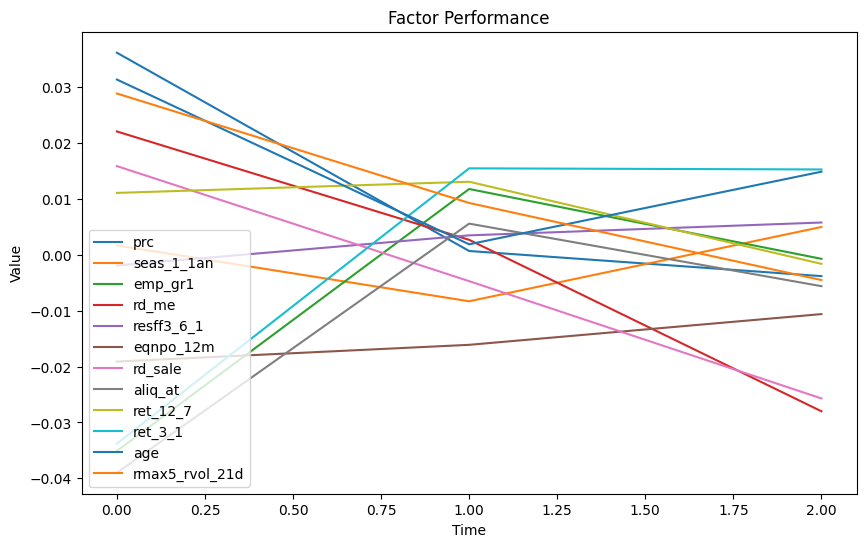

In [81]:
plt.figure(figsize=(10, 6))

# plt.plot(news_3[0][0], df[column], label=column)

# Extract the second value from each sublist in each list of lists
factors = []
for i in range(len(news_1)):
    factor = [news_1[i][1], news_2[i][1], news_3[i][1]]
    factors.append(factor)

# Plot the values
for i in range(len(factors)):
    plt.plot(factors[i], label = news_1[i][0])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Factor Performance')
plt.legend()
plt.show()

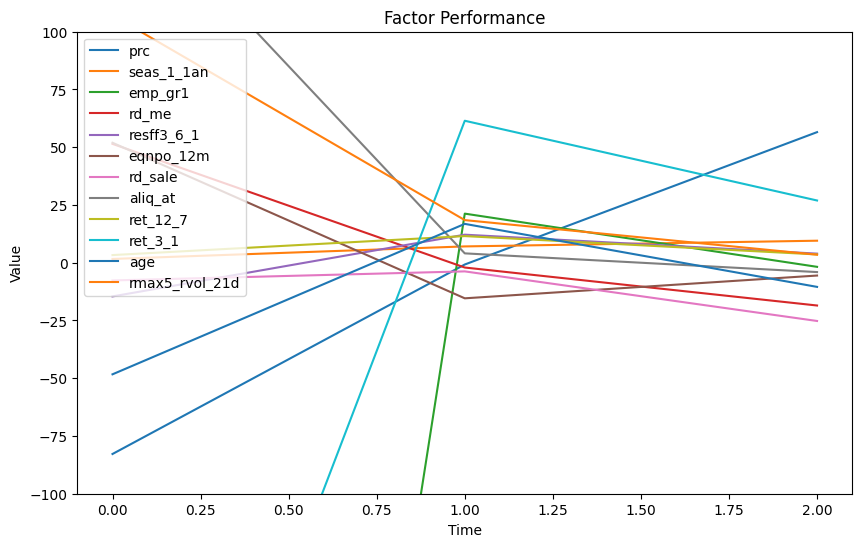

In [82]:
plt.figure(figsize=(10, 6))

# plt.plot(news_3[0][0], df[column], label=column)

# Extract the second value from each sublist in each list of lists
factors = []
for i in range(len(news_1)):
    factor = [news_1[i][2], news_2[i][2], news_3[i][2]]
    factors.append(factor)

# Plot the values
for i in range(len(factors)):
    plt.plot(factors[i], label = news_1[i][0])
plt.ylim(-100,100)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Factor Performance')
plt.legend()
plt.show()